# Minería de Datos: Trabajo Final:

### Importación de las librerías necesarias:

In [2]:
# Importación de bibliotecas estándar
import random
import warnings

# Importación de bibliotecas científicas y de visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Configuración de matplotlib para interactividad
plt.ion()  # Mantén la interactividad de matplotlib

# Configuración de la visualización de diagramas de sklearn
from sklearn import set_config
set_config(display="diagram")

# Importación de herramientas de preprocesamiento
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PolynomialFeatures, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
import category_encoders as ce
from sklearn.decomposition import PCA

# Importación de herramientas de selección de características
from sklearn.feature_selection import SelectKBest, f_classif, SelectPercentile, RFE, RFECV, SequentialFeatureSelector

# Importación de clasificadores
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, BaggingClassifier,
    GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

# Importación de herramientas de evaluación y modelado
from sklearn import neighbors, model_selection, metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

# Importación de técnicas de remuestreo de imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import (
    EditedNearestNeighbours, RepeatedEditedNearestNeighbours, 
    AllKNN, TomekLinks, RandomUnderSampler, NearMiss
)
from imblearn.combine import SMOTEENN, SMOTETomek

# Importación de herramientas evolutivas de DEAP
from deap import base, creator, tools, algorithms

import shap  

from itertools import chain, combinations



# Supresión de warnings
warnings.filterwarnings('ignore')

## 1. Carga de datos:

Leemos los datos:

In [3]:
data_path = 'data/data.csv'
data = pd.read_csv(data_path, index_col=0, na_values=["NA", "?", "null", "n/a", "", " "])
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Análisis de datos:

### 2.1. Análisis de los tipos de datos y detección de nulos:

In [4]:
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Verificamos a ver si hay valores nulos, vacíos o espacios:

In [5]:
# Verificar la cantidad de valores nulos (NaN) en cada columna
conteo_nulos = data.isnull().sum()
print("\nConteo de valores nulos:")
print(conteo_nulos)


Conteo de valores nulos:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


Podemos obsercar que la variable TotalCharges tiene 11 valores nulos.

### 2.2. Distribución de las clases:

Analizamos la distribución de las clases de salida:

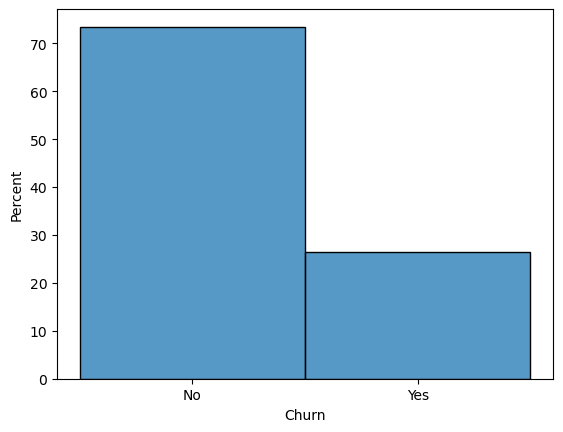

In [6]:
sns.histplot(data=data.loc[:, "Churn"], bins=2, stat='percent', discrete=True)
plt.show()

Podemos observar que se trata de un problema de clasificación desbalanceado.

### 2.3. Ingeniería de variables:

La generación de variables es una técnica clave en el análisis de datos, ya que permite crear nuevas características a partir de las variables originales. Estas nuevas variables pueden ayudarnos a descubrir patrones relevantes que no son evidentes en la base de datos original, y pueden mejorar significativamente el rendimiento de los modelos predictivos o facilitar la interpretación del comportamiento de los clientes según el problema que estemos abordando.

Para ello, generaremos las siguientes variables:

1. **NumServiciosContratados**  
   Cuenta del total de servicios activos por cliente.  
   _Variables base:_ `PhoneService`, `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`.

2. **NumServiciosDeSeguridad**  
   Suma de servicios relacionados con seguridad y soporte.  
   _Incluye:_ `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`.

3. **NumServiciosDeEntretenimiento**  
   Total de servicios de entretenimiento contratados.  
   _Variables:_ `StreamingTV` + `StreamingMovies`.

4. **AntigüedadAlta**  
   Binaria: `1` si `tenure` > 24, `0` si no.  
   Sirve para segmentar clientes nuevos vs fidelizados.

5. **GastoPromedioMensual**  
   Cálculo: `TotalCharges / tenure` (cuando `tenure > 0`).  
   Permite observar si el cliente ha tenido un comportamiento de gasto constante o variable.

6. **TieneDependientesYPartner**  
   Binaria: `1` si `Partner` y `Dependents` son "Yes", `0` si no.  
   Puede indicar mayor estabilidad o compromiso con el servicio.

Para poder crear estas variables, crearemos un componente que se encargue de añadirlas:

In [7]:
class GeneradorVariables(TransformerMixin):

    # Constructor de la clase
    def __init__(self, columns=None):
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        X_aux = X.copy()

        # Obtenemos el número de servicios contratados
        servicios = ["PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup", 
                     "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
        
        X_aux["NumServiciosContratados"] =  X[servicios].apply(lambda row: (row == "Yes").sum(), axis=1).astype(str)

        # Obtenemos el número de servicios de seguridad contratados
        servicios_seguridad = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport"]
        X_aux["NumServiciosSeguridadContratados"] =  X[servicios_seguridad].apply(lambda row: (row == "Yes").sum(), axis=1).astype(str)

        # Obtenemos el número de servicios de entretenimiento contratados
        servicios_entretenimiento = ["StreamingTV", "StreamingMovies"]
        X_aux["NumServiciosEntretenimientoContratados"] =  X[servicios_entretenimiento].apply(lambda row: (row == "Yes").sum(), axis=1).astype(str)

        # Obtenemos si es un cliente antigüo
        X_aux["AntiguedadAlta"] = X["tenure"] > 24

        # Obtenemos el gasto promedio mensual
        X_aux["GastoPromedioMensual"] = np.where(
            X["tenure"] > 0,
            X["TotalCharges"] / X["tenure"],
            X["TotalCharges"]
        )

        # Obtenemos si tiene dependientes y pareja
        X_aux["TieneDependientesYPartner"] = (X["Dependents"] == "Yes") & (X["Partner"] == "Yes")

        # Devolvemos el DataFrame transformado
        return X_aux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"columns": self.columns}

Generamos el dataset con las nuevas variables generadas:

In [8]:
generated_data = GeneradorVariables().transform(data)

Creamos varias listas de variables relevantes que nos ayudarán más adelante:

In [9]:
variables_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges', 'GastoPromedioMensual']

variables_categoricas_nominales = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", 
    "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", 
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", 
    "Contract", "PaperlessBilling", "PaymentMethod", 
    "AntiguedadAlta", "TieneDependientesYPartner"
]

variables_categoricas_ordinales = ['NumServiciosContratados', 'NumServiciosSeguridadContratados', 
    'NumServiciosEntretenimientoContratados']

variablesEntrada = variables_numericas + variables_categoricas_nominales + variables_categoricas_ordinales
variableSalida = "Churn"

### 2.4. Visualización de las distribuciones de las variables:

Visualizamos la distribución de las variables numéricas:

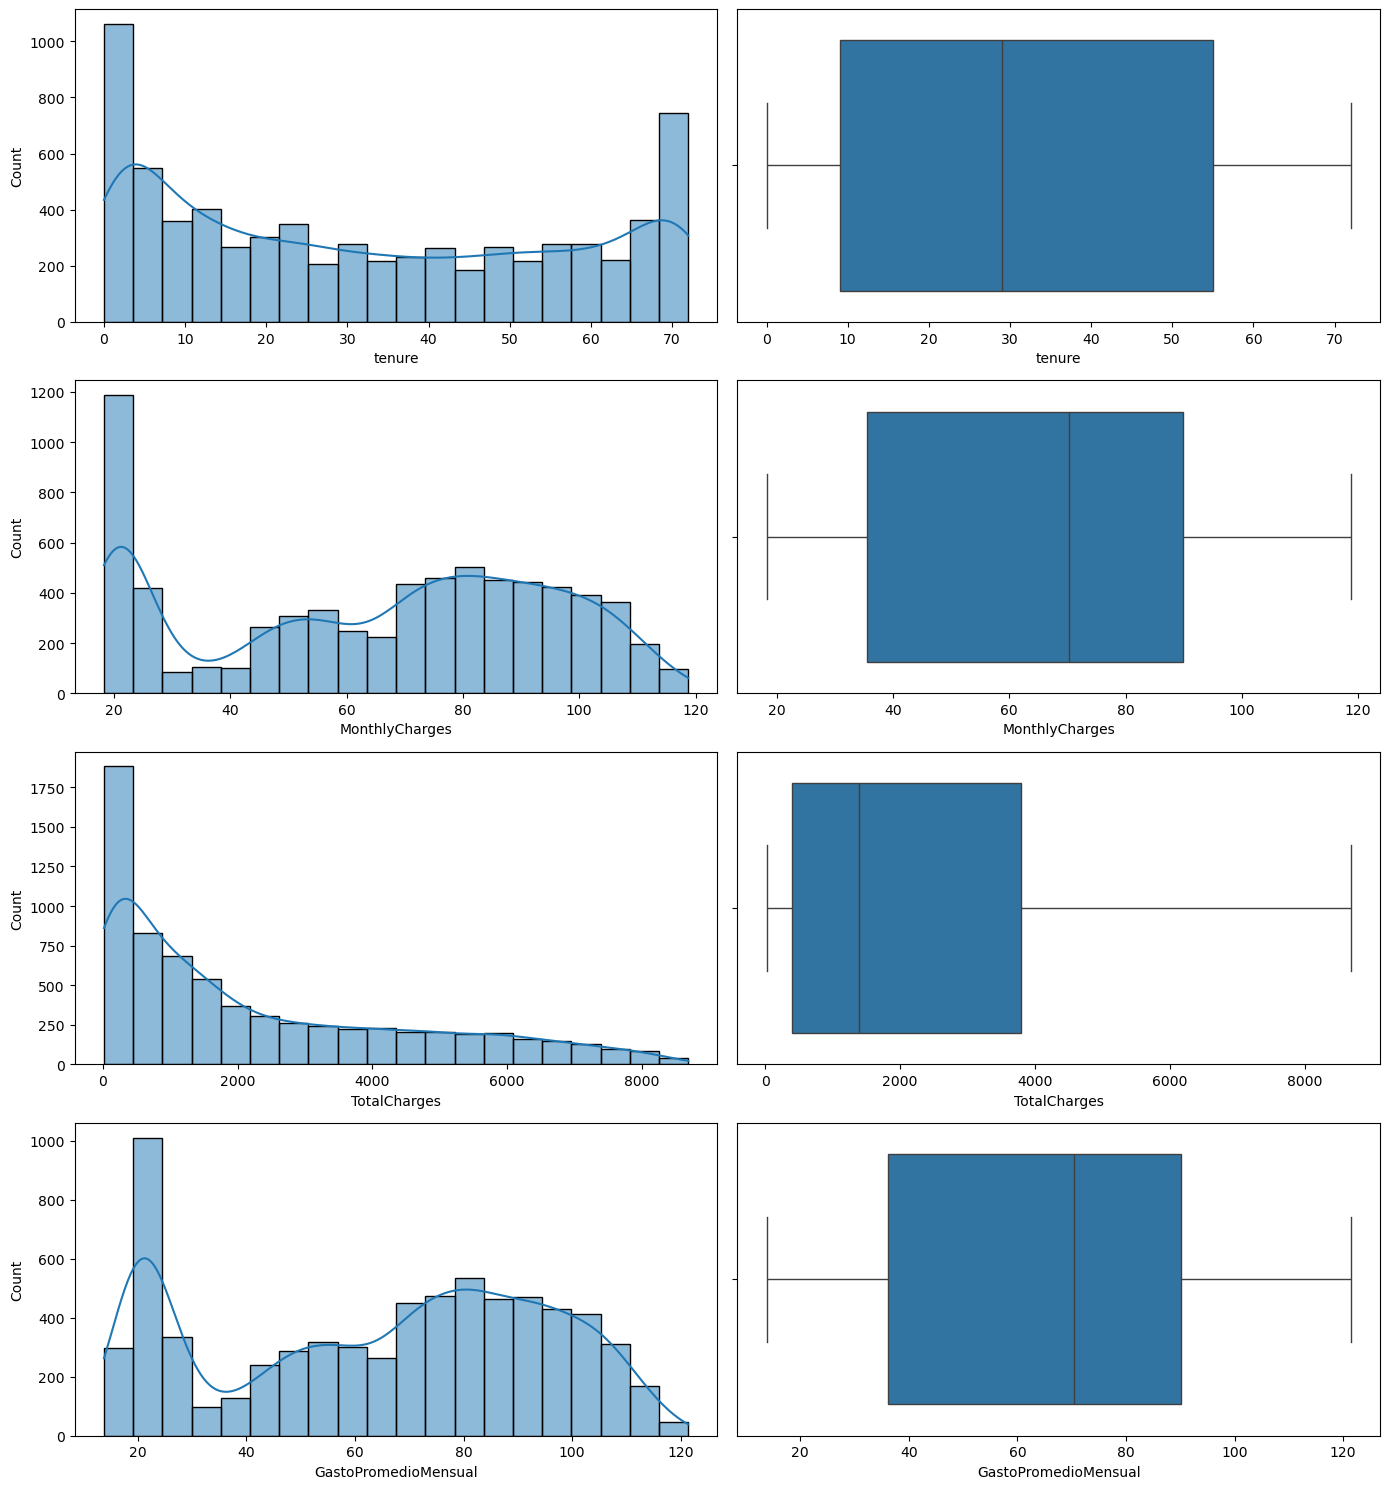

In [10]:
fig, axes = plt.subplots(nrows=len(variables_numericas), ncols=2, figsize=(14, 15))

for i in range(len(variables_numericas)):
    sns.histplot(data=generated_data, x=variables_numericas[i], ax=axes[i, 0], bins=20, kde=True)
    sns.boxplot(data=generated_data, x=variables_numericas[i], ax=axes[i, 1])

fig.tight_layout()

Podemos comprobar que ninguna de las distribuciones se ajusta a una curva normal. Asimismo, a través de los diagramas de caja (box plots) no se identifican valores atípicos según el criterio del rango intercuartil.

Visualizamos la distribución de las variables categóricas:

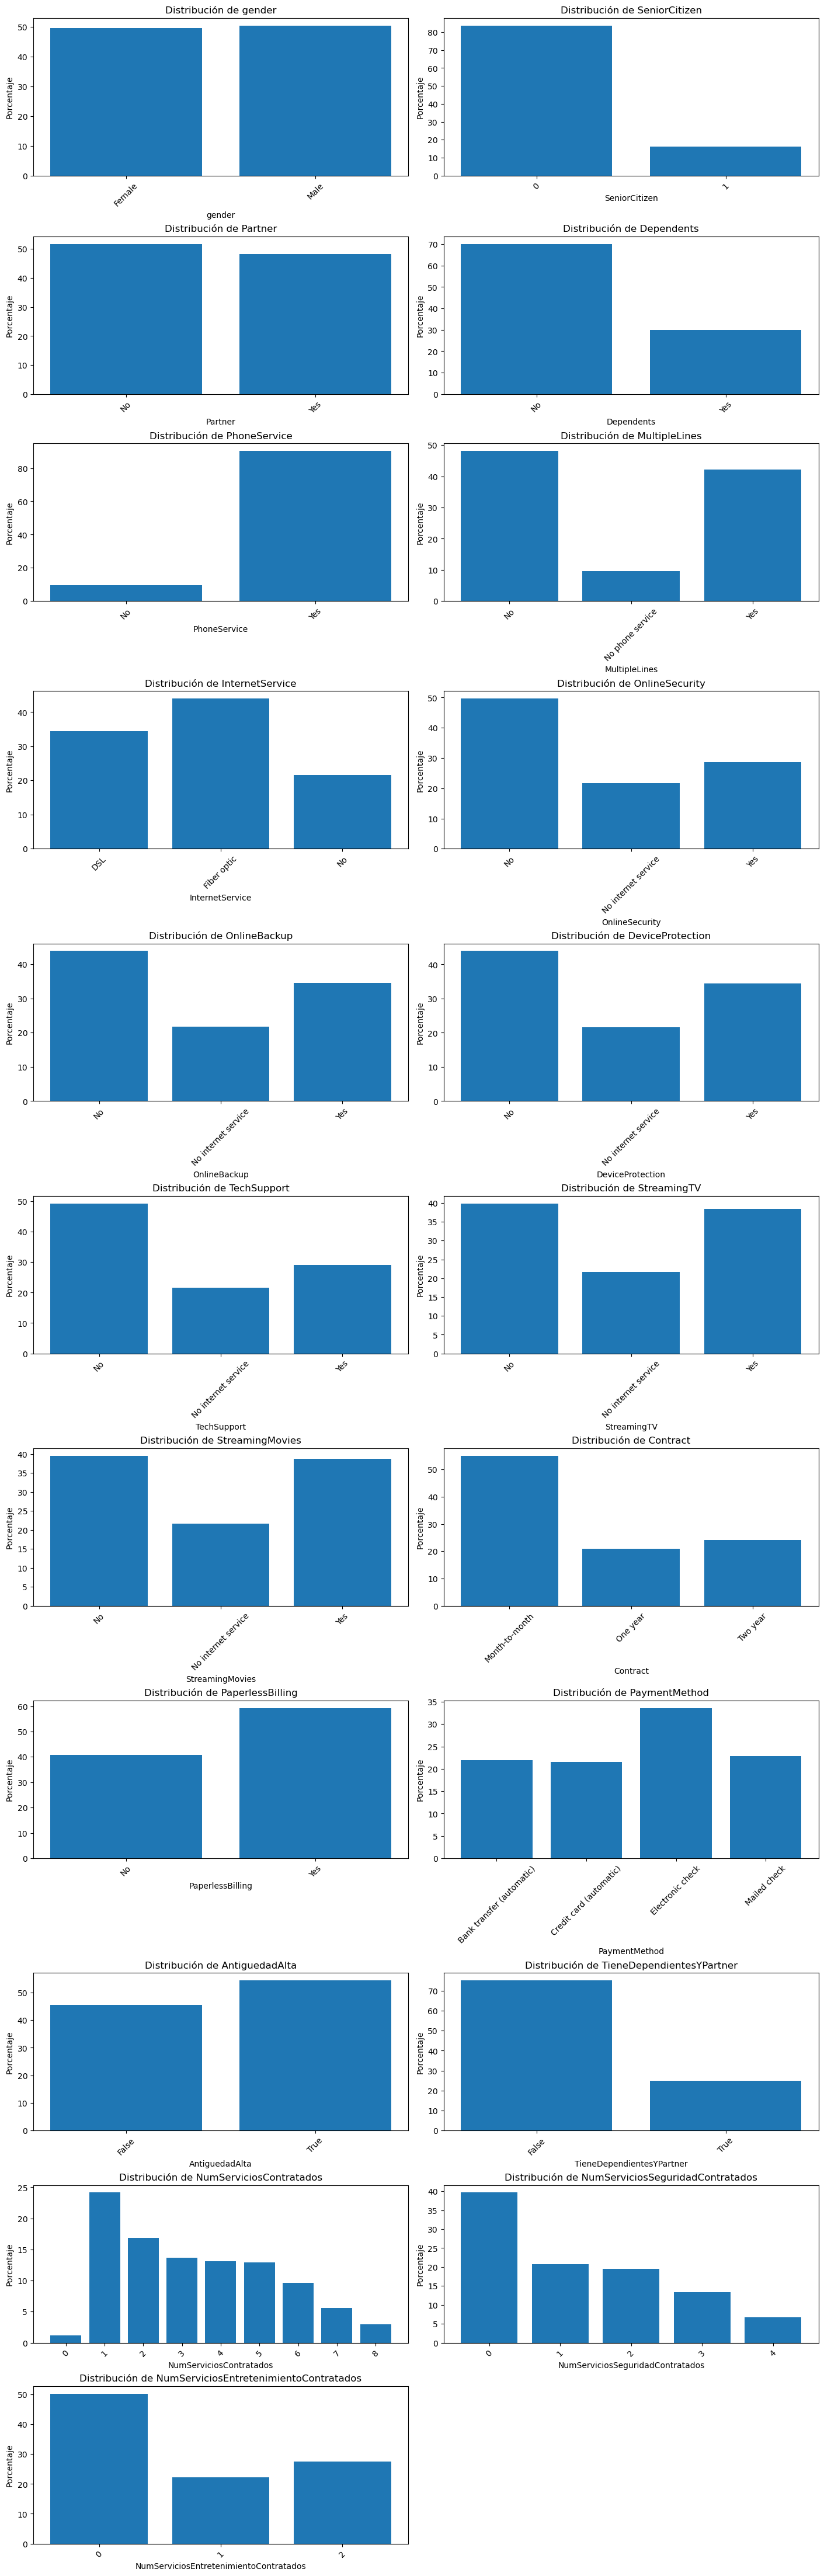

In [11]:
variables_categoricas = variables_categoricas_nominales + variables_categoricas_ordinales

# Parámetros de layout
n_vars = len(variables_categoricas)
cols  = 2                                 # dos columnas
rows  = math.ceil(n_vars / cols)          # filas necesarias
height_per_plot = 4                       # pulgadas por plot

fig, axes = plt.subplots(
    nrows=rows, 
    ncols=cols, 
    figsize=(14, height_per_plot * rows),
    constrained_layout=True
)

# Aplanamos el array de ejes para iterar fácilmente
axes = axes.flatten()

for ax, var in zip(axes, variables_categoricas):
    pct = (
        generated_data[var]
        .value_counts(normalize=True, dropna=True)
        .sort_index() * 100
    )
    ax.bar(pct.index.astype(str), pct.values)
    ax.set_title(f'Distribución de {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Porcentaje')
    ax.tick_params(axis='x', rotation=45)

# Si hay ejes extra (cuando n_vars es impar), los borramos
for ax in axes[n_vars:]:
    fig.delaxes(ax)

plt.show()




1. **Gender**  
   Distribución equilibrada entre “Male” y “Female”.

2. **Senior citizen**  
   Desequilibrada: la mayoría de los clientes **no** son senior citizens.

3. **Partner**  
   Equilibrada: proporción similar de clientes con y sin pareja.

4. **Dependents**  
   Desequilibrada: la mayoría **no** tiene dependientes.

5. **Phone Service**  
   Desequilibrada: la mayoría **sí** dispone de servicio de teléfono.

6. **Multiple Lines**  
   Equilibrio entre “No” y “Yes”, pero existe un segmento de “No phone service”.

7. **Internet Service**  
   Tres categorías (“DSL”, “Fiber optic”, “No”), con predominio de conexiones DSL y Fiber optic sobre “No”.

8. **Online Security / Online Backup / Device Protection / Tech Support**  
   En todas ellas hay más clientes **sin** estos servicios que con ellos, y un subgrupo “No internet service”.

9. **Streaming TV / Streaming Movies**  
   Distribución similar: más clientes **sin** estos servicios que con ellos, y presencia de “No internet service”.

10. **Contract**  
    Predominio del contrato **Monthly** sobre los contratos de 1-year y 2-year.

11. **Paperless Billing**  
    Ligeramente desbalanceada: un poco más de clientes con facturación sin papel.

12. **Payment Method**  
    Una categoría mayoritaria y tres categorías menos frecuentes, relativamente equilibradas entre sí.

13. **Sin Dependents y Sin Partner**  
    La mayoría de los clientes **no** tienen ni pareja ni dependientes simultáneamente.

14. **Antigüedad Alta**  
    Bastante balanceado entre clientes con antigüedad alta y baja.

15. **NumServiciosContratados / NumServiciosSeguridadContratados / NumServiciosEntretenimientoContratados**  
    La mayoría de los usuarios contratan **pocos** servicios; a medida que aumenta el número de servicios contratados, el número de clientes disminuye.


### 2.5. Relación entre las variables de entrada y de salida:

Visualizamos la relación entre las variables numéricas y la salida:

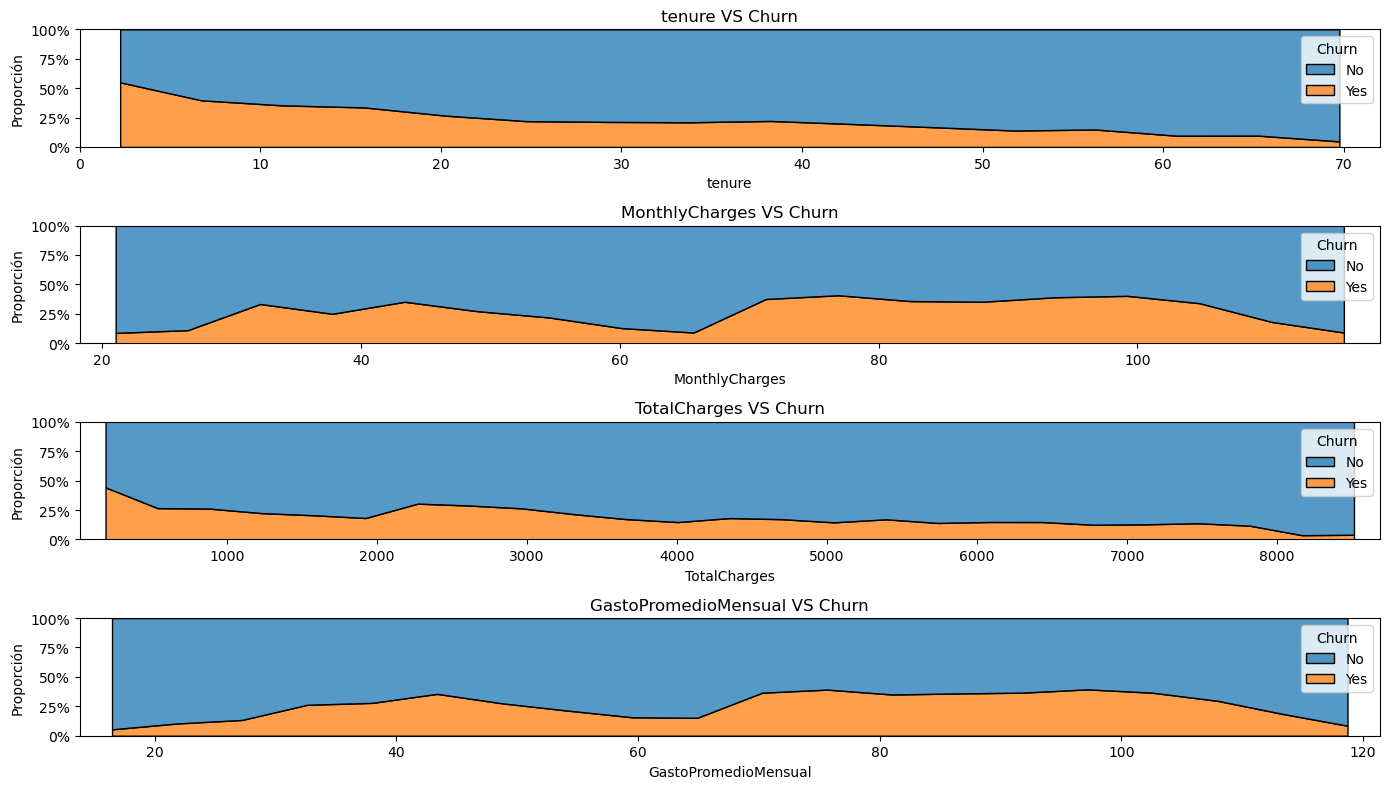

In [12]:
fig, axes = plt.subplots(nrows=len(variables_numericas), ncols=1, figsize=(14, 8))

for i in range(len(variables_numericas)):
    sns.histplot(
        data=generated_data,
        x=variables_numericas[i],
        hue=variableSalida,
        ax=axes[i],
        element='poly',
        stat='probability',
        multiple='fill' 
    )
    axes[i].set_ylabel('Proporción')
    axes[i].set_title(f'{variables_numericas[i]} VS {variableSalida}')
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()


Las dos tendencias más destacadas son:

1. A mayor antigüedad del cliente, menor probabilidad de abandono.  
2. Los clientes con un gasto total reducido muestran un riesgo de fuga más elevado.

Visualizamos la relación entre las variables categóricas y la salida:

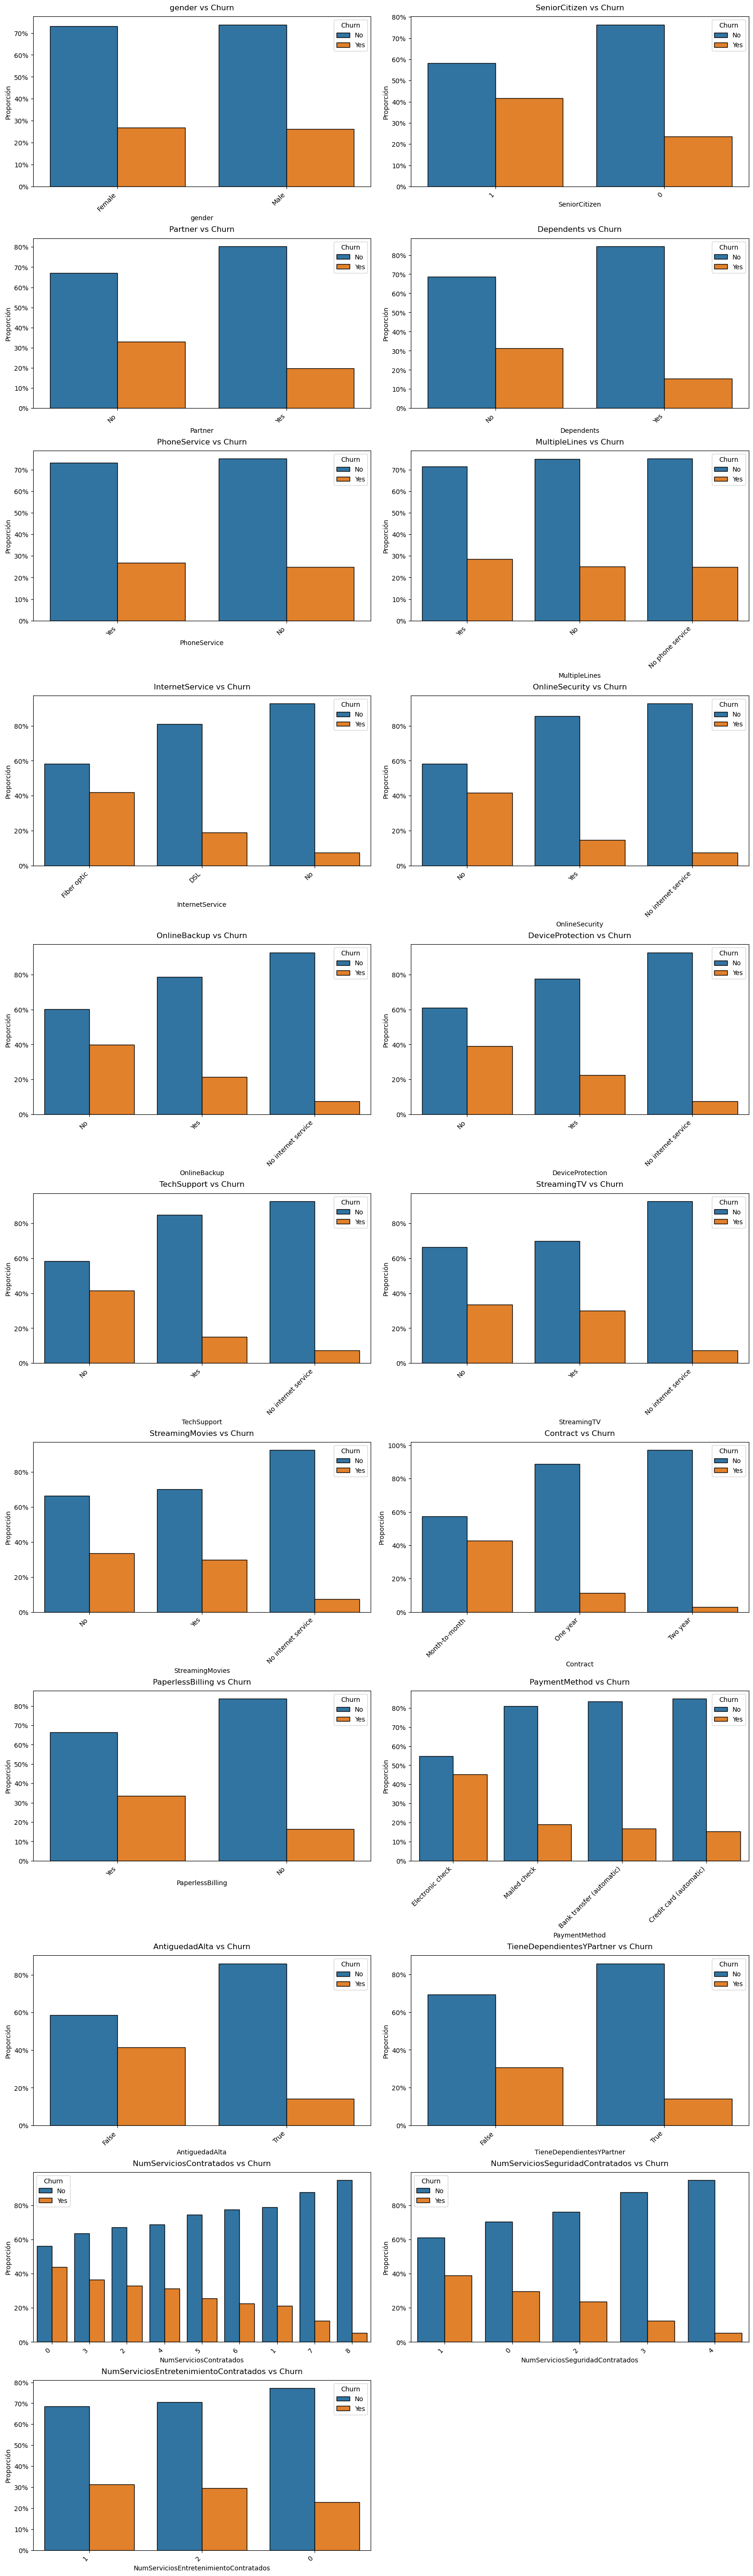

In [13]:

n_vars         = len(variables_categoricas)
cols           = 2
rows           = math.ceil(n_vars / cols)
height_per_row = 5   # pulgadas de alto por fila
fig_width      = 16  # un poco más ancho
fig_height     = height_per_row * rows

fig, axes = plt.subplots(
    nrows=rows,
    ncols=cols,
    figsize=(fig_width, fig_height),
    constrained_layout=True
)
axes = axes.flatten()

for ax, var in zip(axes, variables_categoricas):
    # Calcular conteos y proporciones
    prop_df = (
        generated_data
        .groupby([var, variableSalida])
        .size()
        .reset_index(name='count')
    )
    prop_df['proportion'] = (
        prop_df.groupby(var)['count']
        .transform(lambda x: x / x.sum())
    )

    # Ordenar categorías según P(Yes) descendente
    yes_props = (
        prop_df[prop_df[variableSalida] == 'Yes']
        .set_index(var)['proportion']
        .sort_values(ascending=False)
    )
    order = yes_props.index.tolist()

    # Dibujar el barplot
    sns.barplot(
        data=prop_df,
        x=var,
        y='proportion',
        hue=variableSalida,
        order=order,
        ax=ax,
        edgecolor='black',
        linewidth=1
    )

    # Formato
    ax.set_title(f'{var} vs {variableSalida}', pad=10)
    ax.set_ylabel('Proporción')
    ax.yaxis.set_major_formatter(
        plt.FuncFormatter(lambda y, _: f'{y:.0%}')
    )
    ax.tick_params(axis='x', labelrotation=45)
    for lbl in ax.get_xticklabels():
        lbl.set_ha('right')

# Eliminar ejes sobrantes si n_vars es impar
for ax in axes[n_vars:]:
    fig.delaxes(ax)

plt.show()



1. **Género**  
   La probabilidad de churn es prácticamente idéntica para hombres y mujeres.

2. **Senior Citizen**  
   Los clientes de edad avanzada presentan una tasa de abandono más elevada que los más jóvenes.

3. **Pareja (Partner)**  
   Quienes no tienen pareja muestran mayor riesgo de churn que aquellos con pareja.

4. **Dependientes (Dependents)**  
   La ausencia de dependientes se asocia con una tasa de churn superior.

5. **Servicio Telefónico (Phone Service)**  
   No hay diferencias significativas en churn entre quienes tienen o no servicio telefónico.

6. **Múltiples Líneas (Multiple Lines)**  
   Los clientes con varias líneas muestran un churn ligeramente mayor que los de línea única o sin servicio.

7. **Servicio de Internet (Internet Service)**  
   La fibra óptica presenta la tasa de churn más alta, seguida de DSL; los clientes sin internet tienen la tasa más baja.

8. **Online Security / Online Backup**  
   La falta de estos servicios (incluyendo “No internet service”) se asocia a un mayor churn.

9. **Device Protection / Tech Support**  
   De igual forma, carecer de estos servicios está vinculado a un churn más elevado.

10. **Streaming TV / Streaming Movies**  
    La ausencia de servicios de streaming aumenta la tasa de churn.

11. **Tipo de Contrato (Contract)**  
    El churn es significativamente mayor en contratos mensuales frente a los de 1 o 2 años.

12. **Facturación Electrónica (Paperless Billing)**  
    Los clientes con factura sin papel presentan una tasa de churn algo superior.

13. **Método de Pago (Payment Method)**  
    El churn más elevado se observa en pagos con cheque electrónico; tarjetas de crédito y transferencias automáticas registran las tasas más bajas.

14. **Número de Servicios Contratados**  
    A menor cantidad de servicios (totales, de seguridad o de entretenimiento), mayor es la tasa de churn.

#### Conclusión:

- **Factores que aumentan el churn:**  
  - Ser senior citizen  
  - No tener pareja o dependientes  
  - Pagar con cheque electrónico  
  - Tener contrato mensual  
  - Contar con pocos servicios contratados

- **Factores que reducen el churn:**  
  - Contratos a 1 o 2 años  
  - Pago automático (tarjeta de crédito o transferencia bancaria)  
  - Suscribirse a múltiples servicios adicionales  



### 2.5. Relación entre variables numéricas:

Visualizamos las relaciones entre las variables numéricas:

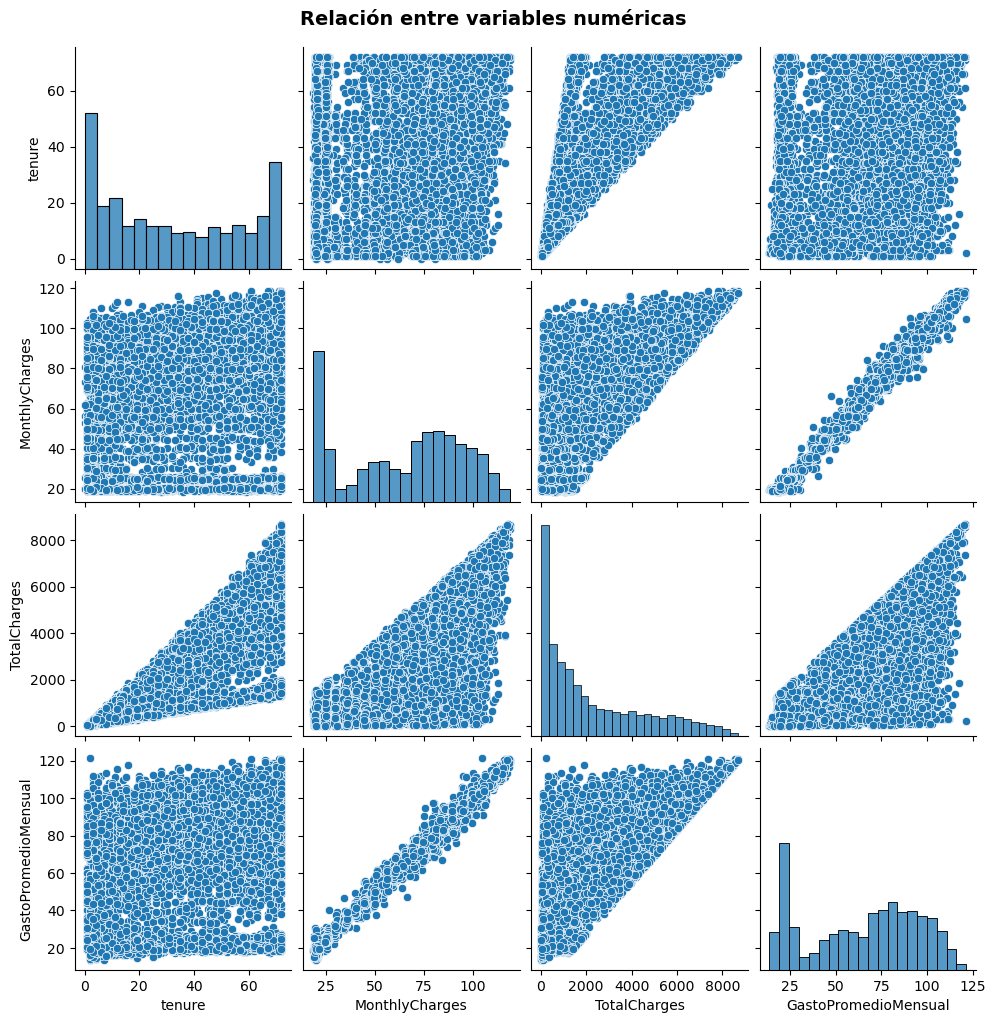

In [14]:
sns.pairplot(data=generated_data[variables_numericas], kind='scatter', diag_kind='hist', height=2.5)
plt.suptitle('Relación entre variables numéricas', y=1.02, fontsize=14, fontweight="bold")
plt.show()

- **Tenure vs. MonthlyCharges**  
  No se aprecia una correlación significativa: la duración del cliente no predice directamente cuánto paga cada mes.

- **Tenure vs. TotalCharges**  
  Existe una relación lineal positiva clara: a mayor antigüedad, mayor es el importe acumulado.

- **MonthlyCharges vs. TotalCharges**  
  Correlación positiva con mayor dispersión: el total depende tanto del cargo mensual como del tiempo que lleva el cliente.

- **GastoPromedioMensual vs. TotalCharges**  
  Fuerte correlación positiva: un gasto medio elevado se traduce en un mayor total facturado.

- **Tenure vs. GastoPromedioMensual**  
  Prácticamente no hay correlación y la dispersión es alta, lo que indica que la permanencia por sí sola no influye en el gasto medio.

- **MonthlyCharges vs. GastoPromedioMensual**  
  Correlación positiva evidente: a más cargo mensual, más alto es el gasto promedio.

Para validar estas observaciones, a continuación calcularemos y visualizaremos la matriz de correlaciones de todas las variables numéricas.


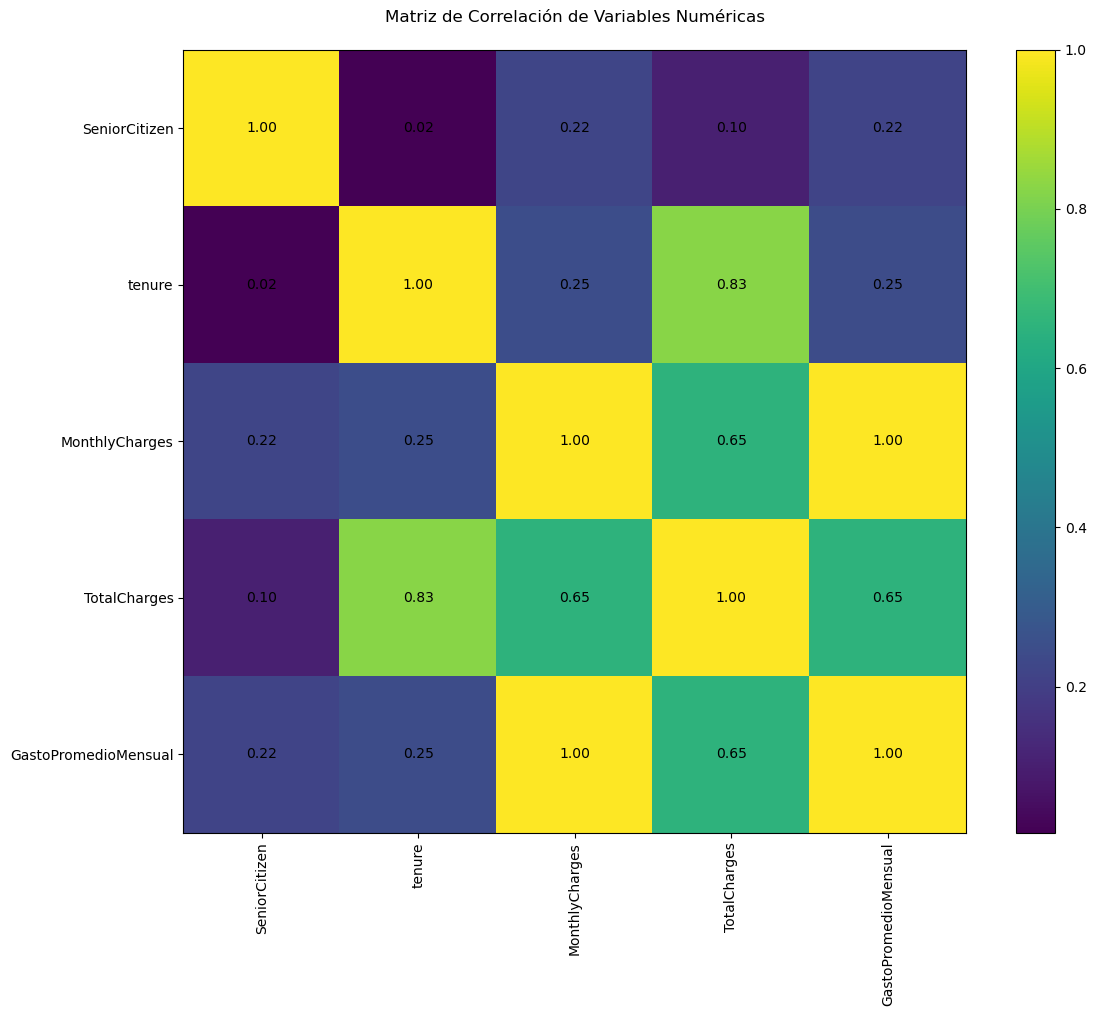

In [15]:
# Filtrar solo columnas numéricas y calcular correlación
numeric_df = generated_data.select_dtypes(include='number')
corr_matrix = numeric_df.corr()

# Crear el heatmap con matplotlib
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(corr_matrix.values, aspect='equal', interpolation='none')

# Añadir barra de color
fig.colorbar(cax, ax=ax)

# Configurar etiquetas de ejes
labels = corr_matrix.columns
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)

# Anotar cada celda con el valor de correlación
for i in range(len(labels)):
    for j in range(len(labels)):
        text = f"{corr_matrix.values[i, j]:.2f}"
        ax.text(j, i, text, ha='center', va='center')

ax.set_title('Matriz de Correlación de Variables Numéricas', pad=20)
plt.tight_layout()
plt.show()


A través de la matriz de correlación, podemos confirmar y visualizar las relaciones observadas entre las variables numéricas.

## 3. Modelo base

Para comenzar a analizar el efecto de las distintas técnicas de minería de datos en la mejora de las predicciones, es necesario establecer un modelo de referencia sobre el cual aplicar las mejoras posteriores.

El modelo base será lo más sencillo posible, utilizando únicamente el preprocesamiento mínimo necesario para permitir que los algoritmos de aprendizaje automático funcionen correctamente. De esta manera, podremos medir de forma clara el impacto de cada técnica adicional aplicada en fases posteriores.

A continuación analizaremos cual es el preprocesamiento mínimo para que un algoritmo de aprendizaje automático funcione con nuestro conjunto de datos.

### 3.1. Etiquetación de los datos:

Actualmente, las etiquetas de la variable objetivo están representadas como `'Yes'` y `'No'`. Para poder utilizar modelos de aprendizaje automático, necesitamos convertir estas etiquetas a valores numéricos. Aplicaremos la siguiente transformación:

- `'Yes'` → `1`
- `'No'` → `0`

In [16]:
# Separamos el dataset en las matrices X e y
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Realizamos la etiquetación
y[y == "Yes"] = 1
y[y == "No"] = 0
y = y.astype(int)

### 3.2. Tratamiento de los valores nulos:

Como se ha mencionado anteriormente, hemos encontrado valores nulos en la variable "TotalCharges". Para que nuestro algoritmo de aprendizaje se pueda ejecutar, necesitamos tratar de alguna manera estos valores.

Como primera solución, utilizaremos un imputador por la media de la variable.

### 3.3. Transformación de variables: categórica a numérica:

En nuestro problema tenemos algunas variables categóricas. Estas deben ser convertidas a numéricas, ya que más adelante, cuando necesitemos aplicar un modelo de aprendizaje automático éstas no podrán ser tratadas. Como primera solución, comenzaremos utilizando la codificación ordinaria por su sencillez.

### 3.4. Modelo de Aprendizaje Automático:

Como modelo base para las pruebas utilizaremos K-Nearest Neighbours con sus valores por defecto.

### 3.5.  Pipelines de preprocesamiento:

Para aplicar el preprocesamiento de manera más sencilla y evitar errores que nos lleven a cometer Data Leakage, crearemos una Pipeline que se encargue de aplicar este preprocesamiento mencionado de manera adecuada.

Primero creamos la Pipeline que preprocesará las variables categóricas:

In [17]:
categorical_preprocessor = Pipeline(steps=[
    ('ordinal_encoder', ce.OrdinalEncoder())
])

Crearemos otra Pipeline que se encargue de preprocesar las variables numéricas con valores faltantes:

In [18]:
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

Creamos un ColumnTransformer que se encargue de transformar todas las variables:

In [19]:
# Creamos el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        # Codificamos las variables categóricas
        ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),

        # Imputamos valores en las variables con valores faltantes
        ('numerical_preprocessor', numerical_preprocessor, variables_numericas),
    ]
)

Probamos la transformación:

In [20]:
# Generamos las nuevas variables
X_modified = GeneradorVariables().transform(X)
# Transformamos los datos
X_modified = preprocessor.fit_transform(X_modified)
# Visualizamos los datos transformados
pd.DataFrame(X_modified).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,0,1,1,1,1,1,1,1,1,...,1,False,False,1,1,1,1.0,29.85,29.85,29.85
1,2,0,2,1,2,2,1,2,2,2,...,2,True,False,2,2,1,34.0,56.95,1889.5,55.573529
2,2,0,2,1,2,2,1,2,1,1,...,2,False,False,2,2,1,2.0,53.85,108.15,54.075
3,2,0,2,1,1,1,1,2,2,2,...,3,True,False,2,3,1,45.0,42.3,1840.75,40.905556
4,1,0,2,1,2,2,2,1,2,1,...,1,False,False,1,4,1,2.0,70.7,151.65,75.825


### 3.6. Creación del modelo:

El modelo base consistirá en el preprocesador creado previamente, combinado con el generador de variables y un KNeighborsClassifier, tal y como se ha mencionado anteriormente. Para facilitar estos pasos, se creará una pipeline que ejecute todos los pasos secuencialmente.

In [21]:
modelo = Pipeline([
    ("var_generator", GeneradorVariables()),
    ("preprocessor", preprocessor),
    ("knn", neighbors.KNeighborsClassifier())
])

modelo

Pipeline(steps=[('var_generator',
                 <__main__.GeneradorVariables object at 0x31fccb0d0>),
                ('preprocessor',
                 ColumnTransformer(transformers=[('categorical_preprocessor',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'Devic...
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'AntiguedadAlta',
                                                   'TieneDependientesYPartner',
                                                   'NumServiciosContratados',
                                                   'NumServiciosSeguridadContratados',
                                                   'NumServiciosEntretenimientoContratados']),
                                                 ('numerical_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'GastoPromedioMensual'])])),
                ('knn', KNeighborsClassifier())])

Definimos una función que entrene el clasificador y mida su rendimiento. Dado que queremos maximizar la precisión y el recall de la clase positiva, utilizaremos el área bajo la curva Precision-Recall (AUC-PR) como media de rendimiento independiente del umbral.

In [22]:
def obtener_resultados(modelo, X_train, y_train, X_val, y_val):
    modelo.fit(X_train, y_train)
    # Calculamos el AUC PR en train
    y_train_prob = modelo.predict_proba(X_train)[:, 1]
    train_auc_pr = metrics.average_precision_score(y_train, y_train_prob) * 100
    # Calculamos el AUC PR en valiación
    y_val_prob = modelo.predict_proba(X_val)[:, 1]
    val_auc_pr = metrics.average_precision_score(y_val, y_val_prob) * 100

    # Calculamos la matriz de confusión en train
    y_train_pred = modelo.predict(X_train)
    cm_train = metrics.confusion_matrix(y_train, y_train_pred)
    # Calculamos la matriz de confusión en valiación
    y_val_pred = modelo.predict(X_val)
    cm_val = metrics.confusion_matrix(y_val, y_val_pred)
    
    return modelo, train_auc_pr, val_auc_pr, cm_train, cm_val

Definimos una función que muestre los resultados calculados con la función anterior:

In [23]:
def mostrar_resultados(train_auc_pr, val_auc_pr, cm_train, cm_val, class_names=None):
    # Imprimir AUC PR
    print(f"AUC-PR (Train): {train_auc_pr:.4f}")
    print(f"AUC-PR (Validación): {val_auc_pr:.4f}")

    # Normalizar matrices por fila (por clase real)
    cm_train_norm = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
    cm_val_norm = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]

    # Configurar los nombres de las clases si no se dan
    if class_names is None:
        class_names = [str(i) for i in range(cm_train.shape[0])]

    # Mostrar mapas de calor con porcentajes
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(
        cm_train_norm,
        annot=True,
        fmt=".1%",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[0]
    )
    axes[0].set_title("Matriz de Confusión - Entrenamiento")
    axes[0].set_xlabel("Etiqueta Predicha")
    axes[0].set_ylabel("Etiqueta Real")

    sns.heatmap(
        cm_val_norm,
        annot=True,
        fmt=".1%",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[1]
    )
    axes[1].set_title("Matriz de Confusión - Validación")
    axes[1].set_xlabel("Etiqueta Predicha")
    axes[1].set_ylabel("Etiqueta Real")

    plt.tight_layout()
    plt.show()

A continuación, para probar los componentes creados, dividiremos los datos en entrenamiento, validación y test. Crearemos dos conjuntos de validación, uno para elegir los distintos componentes de preprocesamiento y otro para escoger el umbral óptimo.

In [24]:
X_train, X_resto, y_train, y_resto = model_selection.train_test_split(X, y, test_size=0.3, stratify=y, random_state=1234)
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_resto, y_resto, test_size=1/3, stratify=y_resto, random_state=1234)
X_val1, X_val2, y_val1, y_val2 = model_selection.train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=1234)

Probamos nuestro modelo base:

AUC-PR (Train): 71.3941
AUC-PR (Validación): 52.5778


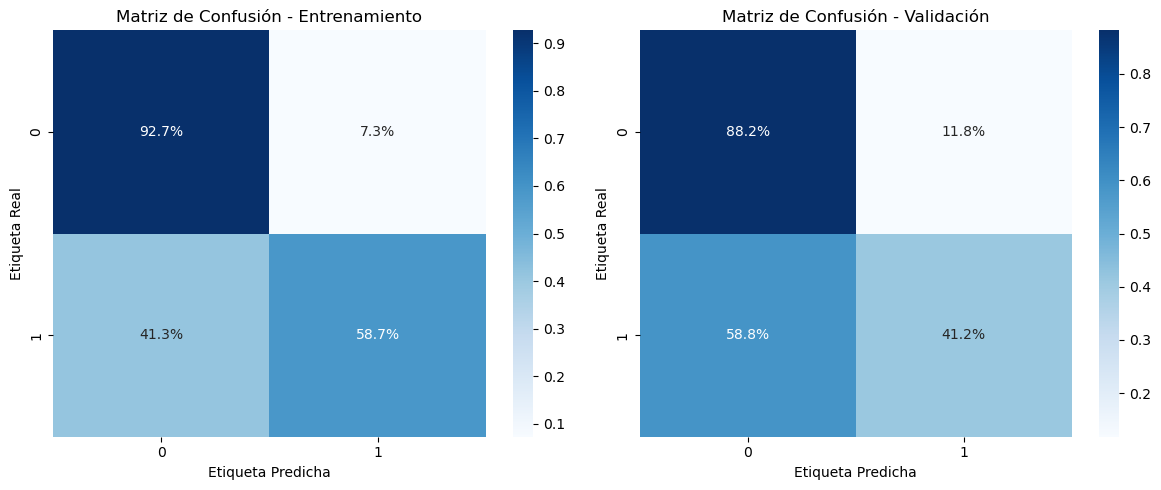

In [25]:
modelo, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val1, y_val1)
mostrar_resultados(train_auc_pr, val_auc_pr, cm_train, cm_val)

## 4. Mejoras en el Preprocesamiento:

En esta sección, exploraremos cómo diversas técnicas de preprocesamiento pueden influir en el rendimiento del modelo base. 

El objetivo principal es identificar las estrategias de preprocesamiento más efectivas que permitan maximizar el área bajo la curva de precisión-recall.

In [26]:
def comparar_resultados(resultados, figsize=(10, 6), y_lim=None):
    nombres = np.array([r['nombre_prueba'] for r in resultados])
    train_scores = np.array([r['train_auc_pr'] for r in resultados])
    val_scores = np.array([r['val_auc_pr'] for r in resultados])
    # Ordenamos los valores según los valores obtenidos en validación
    idx_sorted_val_scores = np.argsort(val_scores)[::-1]
    sorted_train_scores = train_scores[idx_sorted_val_scores]
    sorted_val_scores = val_scores[idx_sorted_val_scores]
    sorted_nombres = nombres[idx_sorted_val_scores]

    n = len(nombres)
    if n > 5:
        n = 5

    x = np.arange(n)  # posiciones en el eje X
    width = 0.35  # ancho de las barras

    fig, ax = plt.subplots(figsize=figsize)
    bars1 = ax.bar(x - width/2, sorted_train_scores[:n], width, label='Train AUC-PR')
    bars2 = ax.bar(x + width/2, sorted_val_scores[:n], width, label='Validation AUC-PR')

    ax.set_ylabel('AUC-PR')
    ax.set_title('Comparación de AUC-PR')
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_nombres[:n], rotation=45, ha='right', fontsize=8)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Aplicar límites del eje Y si se proporciona
    if y_lim is not None:
        ax.set_ylim(y_lim)

    # Mostrar los valores encima de las barras
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

### 4.1. Imputación de valores faltantes:

En este apartado probaremos cómo afecta cada uno de los métodos de imputación de outliers. Probaremos los siguientes métodos:

- Imputación por la media
- Imputación por la mediana
- Imputación por la moda
- Imputación por KNN

Para realizar las pruebas, crearemos una función para visualizar y comparar los resultados:

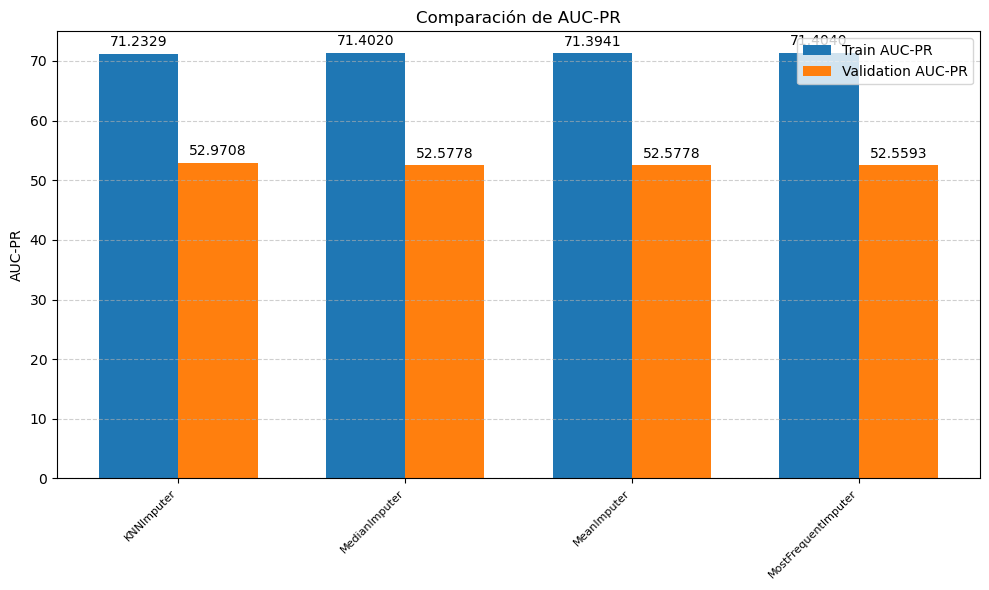

In [27]:
imputers = [("MeanImputer",SimpleImputer(strategy="mean")), 
              ("MedianImputer",SimpleImputer(strategy="median")), 
              ("MostFrequentImputer", SimpleImputer(strategy="most_frequent")),
              ("KNNImputer", KNNImputer())]

resultados = []

for imputer_name, imputer in imputers:
    # Definimos el preprocesador de variables categóricas
    categorical_preprocessor = Pipeline(steps=[
        ('ordinal_encoder', ce.OrdinalEncoder())
    ])

    # Definimos el preprocesador de variables numéricas con valores faltantes
    numerical_preprocessor = Pipeline(steps=[
        ('imputer', imputer)
    ])

    # Creamos el preprocesador final
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
            ('numerical_preprocessor', numerical_preprocessor, variables_numericas)
        ]
    )

    # Creamos el modelo
    modelo = Pipeline([
        ('var_generator', GeneradorVariables()),
        ('preprocessor', preprocessor),
        ('knn', neighbors.KNeighborsClassifier())
    ])

    # Obtenemos los resultados
    _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val1, y_val1)

    # Almacenamos el resultado
    resultado = {"nombre_prueba" : imputer_name,
               "train_auc_pr" : train_auc_pr,
               "val_auc_pr" : val_auc_pr}
    
    resultados.append(resultado)
    
comparar_resultados(resultados)

No se observa una gran diferencia entre el uso de distintos imputadores. Esto puede deberse a la baja cantidad de valores faltantes en el conjunto de datos, o a que la variable con valores faltantes no tiene un impacto significativo en la tarea de clasificación.

### 4.2. Codificación de las variables categóricas:

A continuación analizaremos el efecto de distintos métodos para codificar variables categóricas en variables numéricas. Probaremos los siguientes métodos:

- Codificación por conteo
- Codificación ordinal
- Codificación binaria
- Codificación One Hot Encoding
- Codificación basada en la salida del problema de clasificación

Hay que tener en cuenta que dentro de las variables categóricas tenemos dos clases, las ordinales y las nominales. Por tanto, utilizaremos distintas codificaciones para cada una de estas.

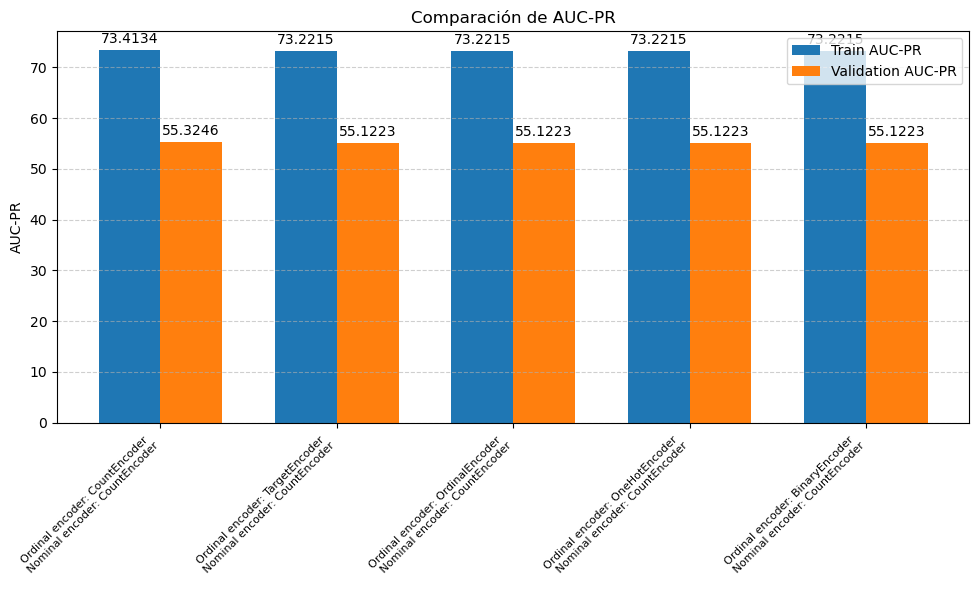

In [28]:
encoders = [("BinaryEncoder", ce.BinaryEncoder()), 
            ("OneHotEncoder", ce.OneHotEncoder()), 
            ("CountEncoder", ce.CountEncoder()), 
            ("OrdinalEncoder", ce.OrdinalEncoder()), 
            ("TargetEncoder", ce.TargetEncoder())]

resultados = []

for nominal_encoder_name, nominal_encoder in encoders:
    for ordinal_encoder_name, ordinal_encoder in encoders:
        # Definimos el preprocesador de variables categóricas nominales
        nominal_categorical_preprocessor = Pipeline(steps=[
            ('nominal_encoder', nominal_encoder)
        ])
        # Definimos el preprocesador de variables categóricas ordinales
        ordinal_categorical_preprocessor = Pipeline(steps=[
            ('ordinal_encoder', ordinal_encoder)
        ])

        # Definimos el preprocesador de variables numéricas con valores faltantes
        numerical_preprocessor = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy="mean"))
        ])

        # Creamos el preprocesador final
        preprocessor = ColumnTransformer(
            transformers=[
                ('nominal_categorical_preprocessor', nominal_categorical_preprocessor, variables_categoricas_nominales),
                ('ordinal_categorical_preprocessor', ordinal_categorical_preprocessor, variables_categoricas_ordinales),
                ('numerical_preprocessor', numerical_preprocessor, variables_numericas)
            ]
        )

        # Creamos el modelo
        modelo = Pipeline([
            ('var_generator', GeneradorVariables()),
            ('preprocessor', preprocessor),
            ('knn', neighbors.KNeighborsClassifier())
        ])
        # Obtenemos los resultados
        _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val1, y_val1)
        
        nombre_prueba = f"Ordinal encoder: {ordinal_encoder_name} \n Nominal encoder: {nominal_encoder_name}"
        resultado = {"nombre_prueba" : nombre_prueba,
                "train_auc_pr" : train_auc_pr,
                "val_auc_pr" : val_auc_pr}
        
        resultados.append(resultado)

comparar_resultados(resultados)

Podemos observar que el codificador que ofrece mejores resultados, tanto para las variables categóricas **ordinales** como **nominales**, es el **`CountEncoder`**. Este comportamiento es coherente con el uso de un modelo **K-Nearest Neighbors (KNN)**, ya que este tipo de codificación facilita la distinción entre valores frecuentes y poco frecuentes. Esto sugiere que la frecuencia de las categorías tiene un peso importante en el proceso de clasificación.

En concreto, al codificar las categorías según su frecuencia de aparición en el conjunto de datos, la diferencia numérica entre una categoría común y una rara se vuelve significativa. Esto ayuda al algoritmo de vecinos más cercanos a capturar mejor la relación entre los ejemplos, ya que las distancias reflejan, de forma implícita, la representatividad de cada valor.

Además de facilitar esta distinción, `CountEncoder` presenta otra ventaja importante: **no incrementa la dimensionalidad del dataset**. A diferencia de otros métodos como `OneHotEncoder`, no genera columnas adicionales, lo que implica un menor **coste computacional** y una mayor eficiencia, especialmente en conjuntos de datos con muchas categorías.

### 4.3. Transformación de variables

Durante el análisis exploratorio se observó que las variables numéricas no siguen una distribución normal. Por ello, aplicaremos diversas transformaciones con el objetivo de aproximarlas a una distribución normal. Las transformaciones consideradas son:

- Transformación logarítmica  
- Transformación de raíz cuadrada  
- Transformación Box-Cox o Yeo-Johnson (según el dominio de la variable)  
- Transformación basada en cuantiles (Quantile Transformation)

Evaluaremos visualmente el efecto de cada una de estas transformaciones sobre la distribución de las variables numéricas.

Primero crearemos una función para visualizar dichas transformaciones:

In [29]:
def visualizar_transformaciones(df, variables):
    for var in variables:
        fig, axes = plt.subplots(1, 5, figsize=(30, 6))  # Ahora hay 6 subgráficas
        fig.suptitle(f'Transformaciones para la variable: {var}', fontsize=16)
        
        col_original = df[var]
        
        # Asegurar que los datos sean positivos para log, sqrt
        if (col_original <= 0).any():
            shift = abs(col_original.min()) + 1
            col_pos = col_original + shift
        else:
            shift = 0
            col_pos = col_original.copy()

        # Original
        axes[0].hist(col_original.dropna(), bins=30, color='skyblue')
        axes[0].set_title('Original')

        # Raíz Cuadrada (Sqrt)
        axes[1].hist(np.sqrt(col_pos).dropna(), bins=30, color='orange')
        axes[1].set_title('Sqrt')

        # Logaritmo (Log)
        axes[2].hist(np.log(col_pos).dropna(), bins=30, color='green')
        axes[2].set_title('Log')

        # Box-Cox / Yeo-Johnson (usando PowerTransformer de scikit-learn)
        power_transformer = PowerTransformer(method='box-cox' if (col_pos > 0).all() else 'yeo-johnson')
        transformed_power = power_transformer.fit_transform(col_pos.values.reshape(-1, 1))
        axes[3].hist(transformed_power, bins=30, color='red')
        axes[3].set_title('Box-Cox / Yeo-Johnson')

        # Quantile Transformation (Transformación basada en cuantiles)
        quantile_transformer = QuantileTransformer(output_distribution='normal')
        transformed_quantiles = quantile_transformer.fit_transform(col_pos.values.reshape(-1, 1))
        axes[4].hist(transformed_quantiles, bins=30, color='purple')
        axes[4].set_title('Quantile Transformation')

        # Mostrar las gráficas
        for ax in axes:
            ax.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

Visualizamos las transformaciones:

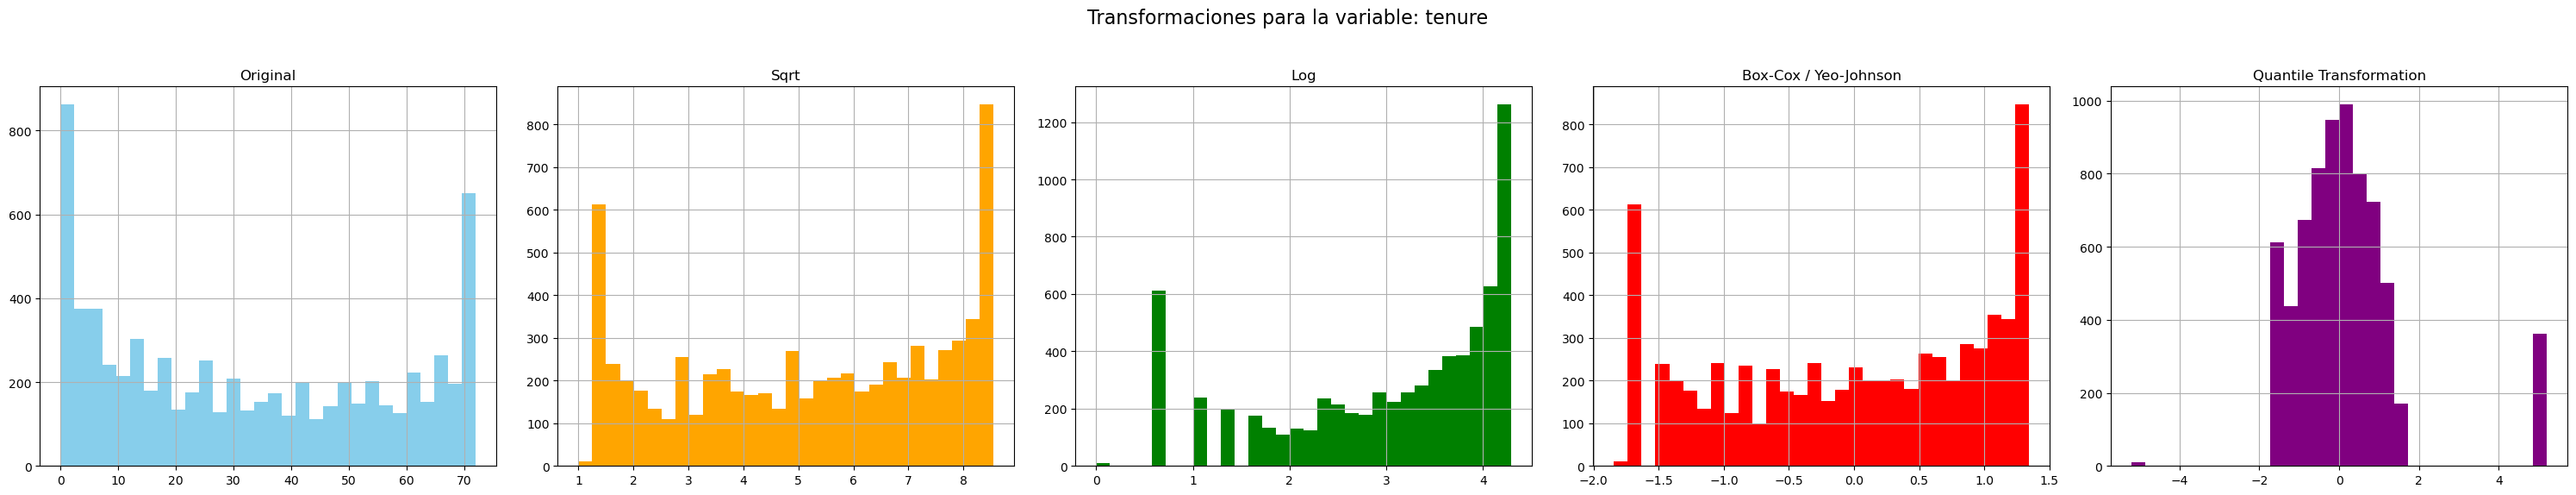

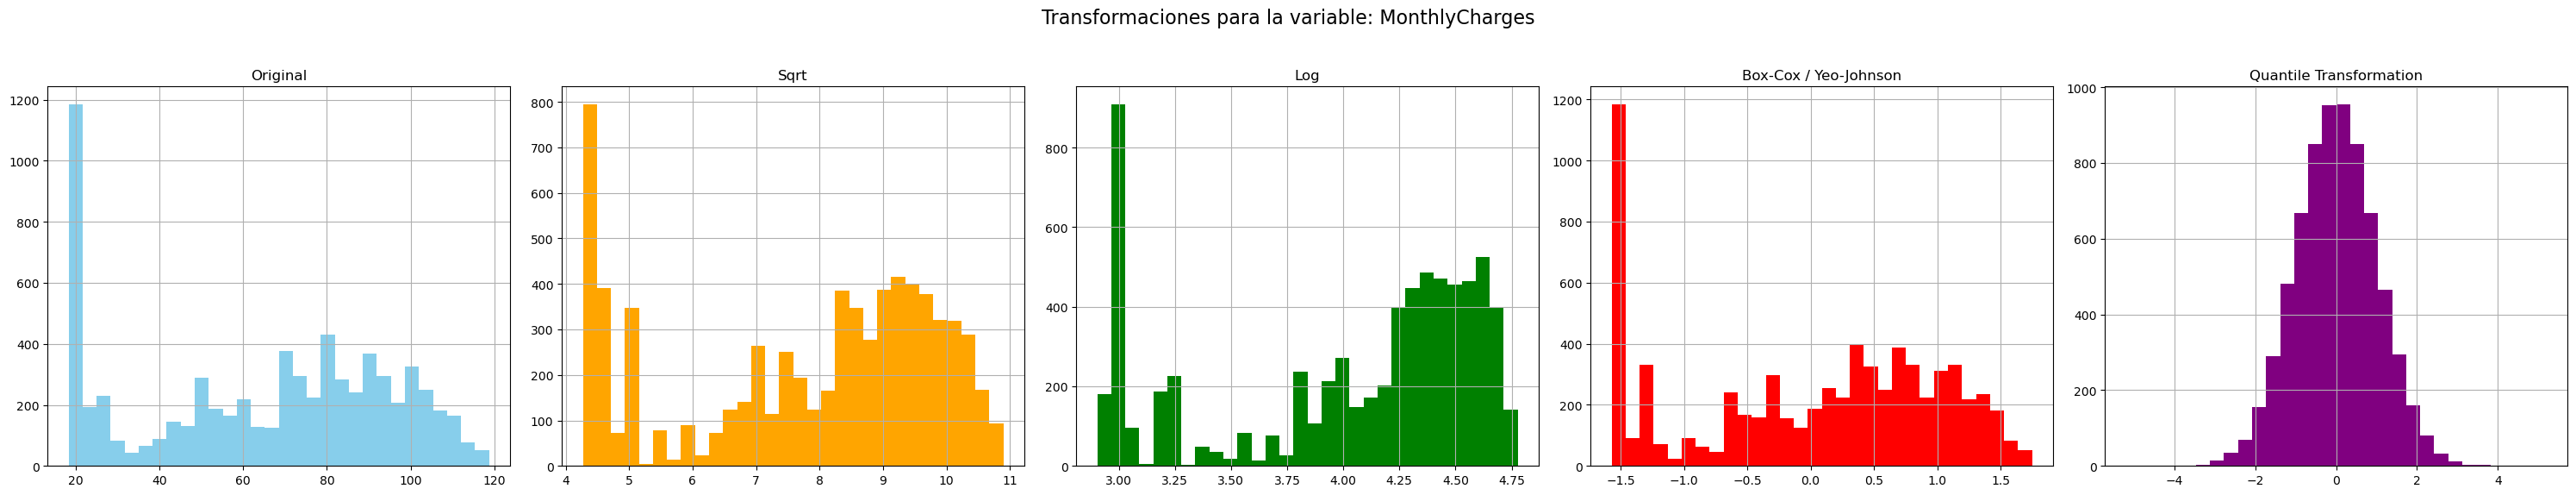

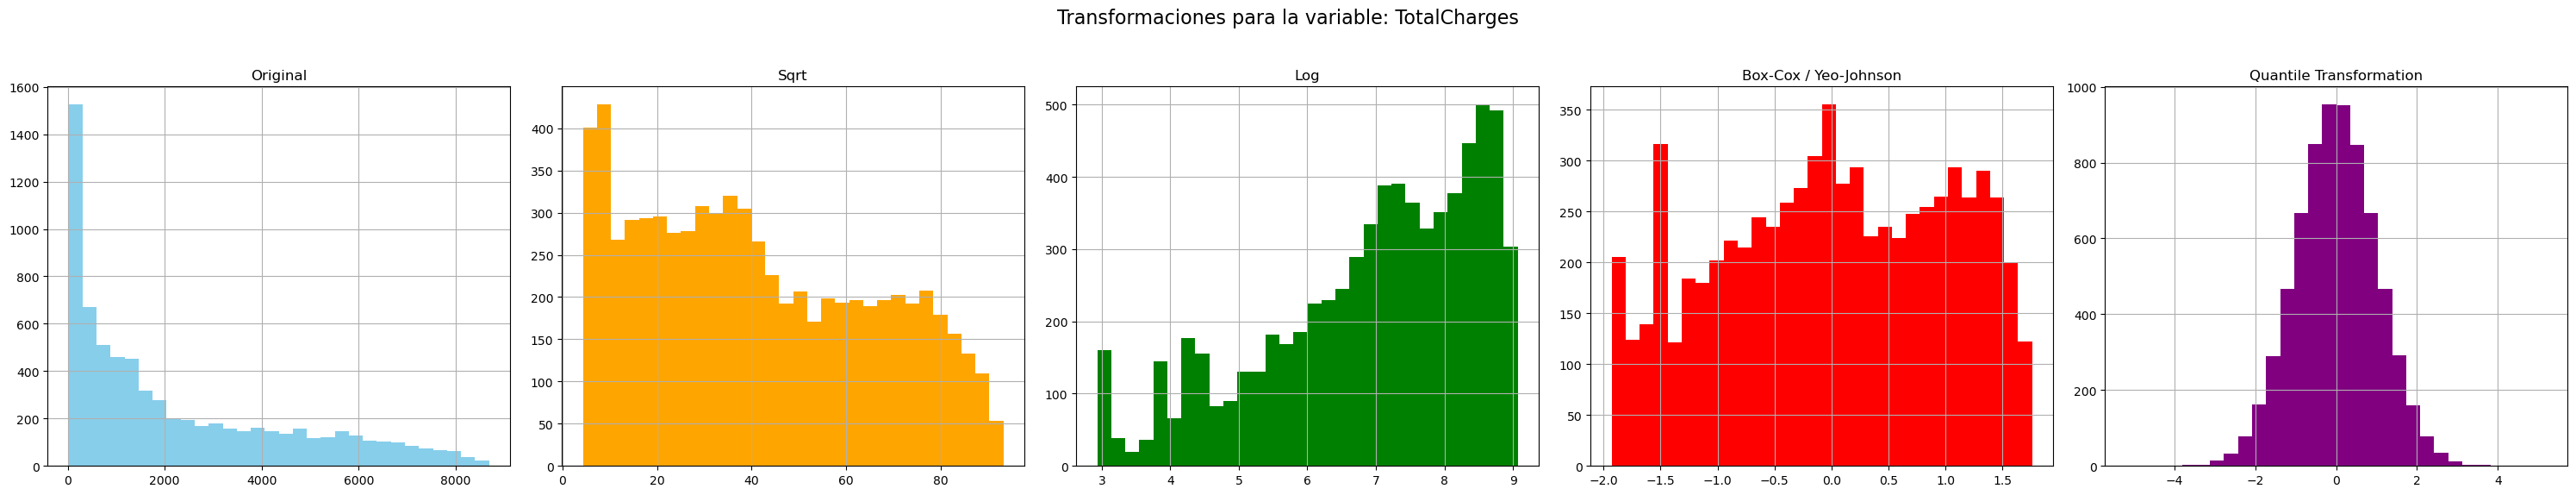

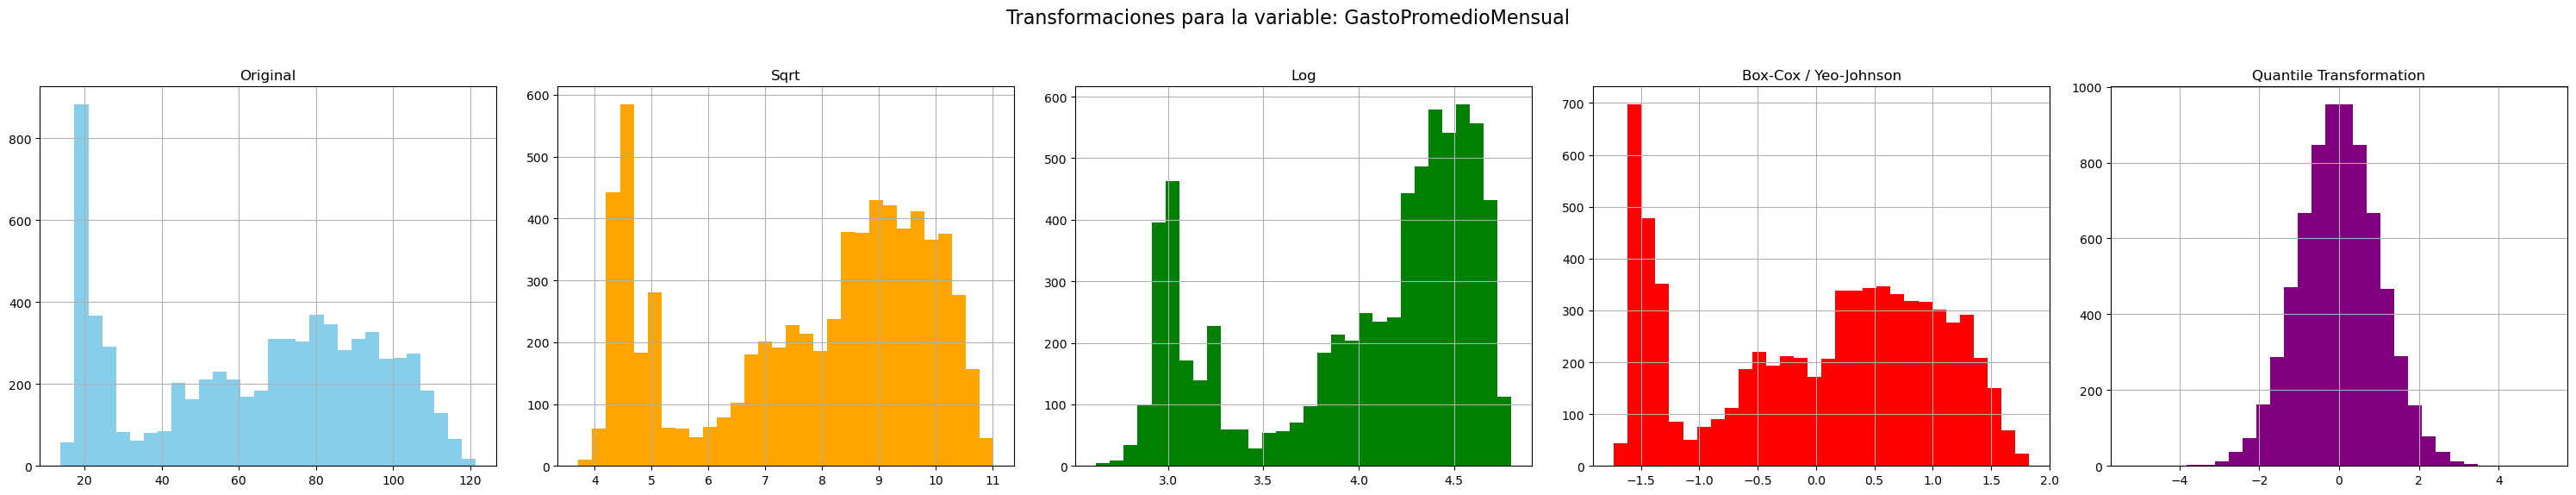

In [30]:
visualizar_transformaciones(generated_data, variables_numericas)

Como se puede observar, la transformación basada en cuantiles es la que mejor aproxima las variables numéricas a una distribución normal. 

Para evaluar su impacto en el rendimiento del modelo, probaremos distintas combinaciones en el preprocesamiento. En concreto, analizaremos si aplicar o no esta transformación de forma individual para cada variable mejora la capacidad de clasificación.

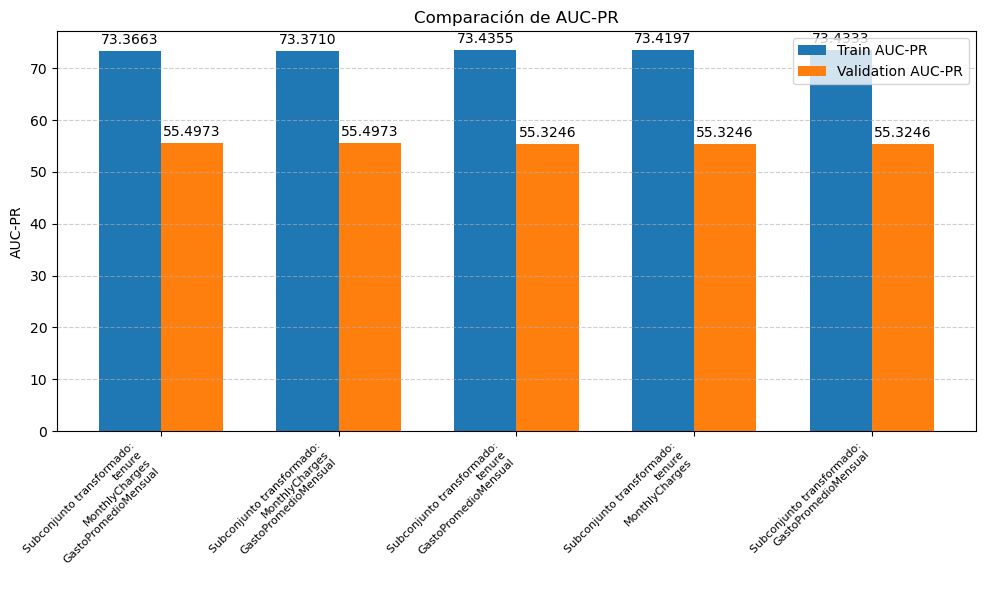

In [31]:
subconjuntos = list(chain.from_iterable(combinations(variables_numericas, r) for r in range(len(variables_numericas)+1)))
resultados = []

for subconjunto_trans in subconjuntos:
        subconjunto_no_trans = [v for v in variables_numericas if v not in subconjunto_trans]
        # Definimos el preprocesador de variables categóricas
        categorical_preprocessor = Pipeline(steps=[
            ('encoder', ce.CountEncoder())

        ])
        
        # Definimos el preprocesador de variables numéricas con QuantileTransformer
        numerical_trans_preprocessor = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy="mean")),
            ('transformer', QuantileTransformer())
        ])

        # Definimos el preprocesador de variables numéricas 
        numerical_preprocessor = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy="mean"))
        ])

        # Creamos el preprocesador final
        preprocessor = ColumnTransformer(
            transformers=[
                ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
                ('numerical_trans_preprocessor', numerical_trans_preprocessor, subconjunto_trans),
                ('numerical_preprocessor', numerical_preprocessor, subconjunto_no_trans)
            ]
        )

        # Creamos el modelo
        modelo = Pipeline([
            ('var_generator', GeneradorVariables()),
            ('preprocessor', preprocessor),
            ('knn', neighbors.KNeighborsClassifier())
        ])

        # Obtenemos los resultados
        _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val1, y_val1)
        
        nombre_prueba = "Subconjunto transformado:\n" + "\n".join(subconjunto_trans)
        resultado = {"nombre_prueba" : nombre_prueba,
                "train_auc_pr" : train_auc_pr,
                "val_auc_pr" : val_auc_pr}
        
        resultados.append(resultado)

comparar_resultados(resultados)

Dado que transformar las variables `tenure`, `MonthlyCharges` y `GastoPromedioMensual` contribuye a una ligera mejora en el AUC-PR, decidimos mantener dicha transformación en el preprocesamiento. Esta mejora probablemente se deba a que el modelo KNN tiende a funcionar mejor cuando las variables numéricas siguen una distribución aproximadamente normal. 

Además, trabajar con variables normalizadas facilita procesos posteriores como la detección de outliers o la aplicación de técnicas de escalado, mejorando así la estabilidad y el rendimiento general del modelo.

Para facilitar estos fututos procesos, crearemos una lista con las variables a transformar:

In [32]:
variables_numericas_trans = ["tenure", "MonthlyCharges", "GastoPromedioMensual"]
variables_numericas_no_trans = ["TotalCharges"]

### 4.4. Normalización de las variables:

En este apartado, visualizaremos el efecto de la normalización sobre las variables **numéricas** y **categóricas**. Para las variables numéricas, probaremos los siguientes métodos de normalización:

- **Estandarización mediante la media y la desviación estándar (Z-score)**.
- **Estandarización mediante el mínimo y el máximo (min-max)**.

Para las variables categóricas, únicamente probaremos la **normalización min-max**, ya que el uso del Z-score podría distorsionar los patrones de **rareza** que son cruciales para modelos como **KNN**, los cuales se benefician de la frecuencia de aparición de las categorías.

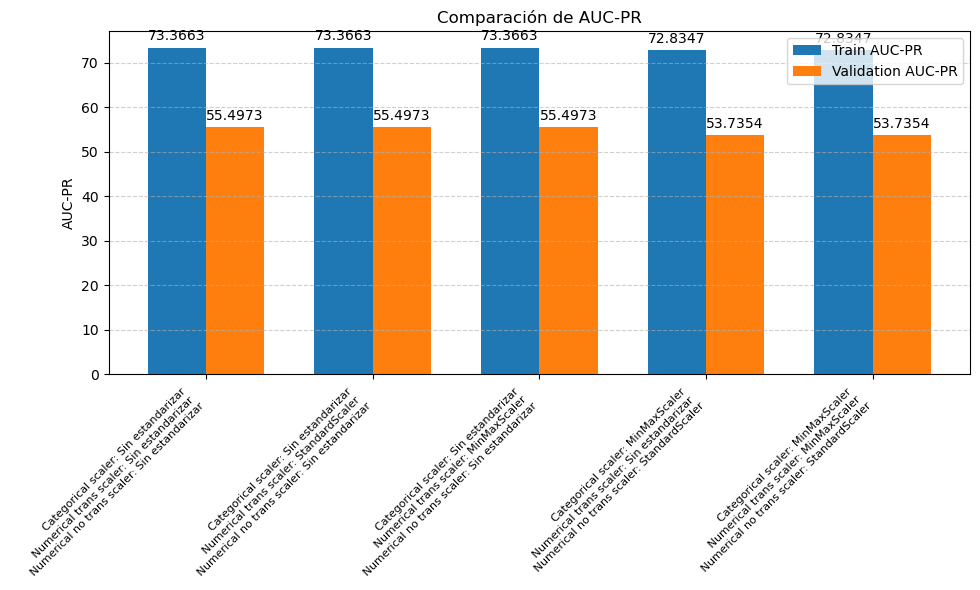

In [33]:
numerical_scalers = [("Sin estandarizar", "passthrough"), 
                     ("StandardScaler", StandardScaler()),
                     ("MinMaxScaler", MinMaxScaler())]

categorical_scalers = [("Sin estandarizar", "passthrough"),
                       ("MinMaxScaler", MinMaxScaler())]

resultados = []

for numerical_scaler_name, numerical_scaler in numerical_scalers:
    for numerical_trans_scaler_name, numerical_trans_scaler in numerical_scalers:
        for categorical_scaler_name, categorical_scaler in categorical_scalers:
            # Definimos el preprocesador de variables categóricas
            categorical_preprocessor = Pipeline(steps=[
                ('encoder', ce.CountEncoder()),
                ('scaler', categorical_scaler)

            ])

            # Definimos el preprocesador de variables numéricas con QuantileTransformer
            numerical_trans_preprocessor = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy="mean")),
                ('transformer', QuantileTransformer()),
                ('scaler', numerical_trans_scaler)
            ])

            # Definimos el preprocesador de variables numéricas 
            numerical_preprocessor = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy="mean")),
                ('scaler', numerical_scaler)
            ])

            # Creamos el preprocesador final
            preprocessor = ColumnTransformer(
                transformers=[
                    ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
                    ('numerical_trans_preprocessor', numerical_trans_preprocessor, variables_numericas_trans),
                    ('numerical_preprocessor', numerical_preprocessor, variables_numericas_no_trans)
                ]
            )

            # Creamos el modelo
            modelo = Pipeline([
                ('var_generator', GeneradorVariables()),
                ('preprocessor', preprocessor),
                ('knn', neighbors.KNeighborsClassifier())
            ])

            # Obtenemos los resultados
            _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val1, y_val1)
            
            nombre_prueba = f"Categorical scaler: {categorical_scaler_name} \n Numerical trans scaler: {numerical_trans_scaler_name} \n Numerical no trans scaler: {numerical_scaler_name}"
            resultado = {"nombre_prueba" : nombre_prueba,
                    "train_auc_pr" : train_auc_pr,
                    "val_auc_pr" : val_auc_pr}
            
            resultados.append(resultado)

comparar_resultados(resultados)

Podemos observar que la opción más conveniente es **no normalizar las variables numéricas**. Esto probablemente se debe a que algunas de las variables tienen una **alta relevancia** en el modelo. Al aplicar una normalización, se reduce su **escala relativa**, lo que disminuye su influencia en el cálculo de distancias, especialmente en modelos como **KNN**. Como resultado, su contribución a la clasificación final se vuelve **menos significativa** en comparación con mantenerlas en su **escala original**.

### 4.5. Detección de outliers:

En este apartado, analizaremos el efecto de la **detección de outliers** en las variables numéricas. Para ello, probaremos los siguientes métodos de detección:

- **Detección de outliers mediante el método de la media y la desviación estándar.**
- **Detección de outliers mediante el método del rango intercuartil (IQR).**

Cada uno de los componentes los probaremos con k = 1, 2 y 3.

Creamos los componentes encargados de detectar outliers mediante el método del rango intercuartil. En el primero, sustituiremos los outliers por la mediana:

In [34]:
class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X[self.columns].describe()
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calcula el IQR de cada variable
        IQRs = self.stats.loc['75%'] - self.stats.loc['25%']
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc['25%'] - self.k * IQRs
        limiteSup = self.stats.loc['75%'] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = X[self.columns] < limiteInf
        mayores = X[self.columns] > limiteSup

        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = np.logical_or(menores[c], mayores[c])
            # Si hay outliers
            for idx in X[indices].index:
                # Los sustituimos por la mediana
                Xaux.at[idx, c] = self.stats.loc['50%'][c]
                
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

En este segundo componente, sustituiremos los outliers por el mínimo o el máximo:

In [35]:
class OutlierDetectionClipping_IQR(OutlierDetecion_treatment_IQR):
    # Constructor de la clase
    def __init__(self, k=2, columns=None):
        self.k = k
        self.columns = columns

    def transform(self, X):
        """Versión que reemplaza outliers por los límites (clipping) en lugar de la mediana"""
        X = pd.DataFrame(X)
        Xaux = X.copy()
        IQRs = self.stats.loc['75%'] - self.stats.loc['25%']
        limiteInf = self.stats.loc['25%'] - self.k * IQRs
        limiteSup = self.stats.loc['75%'] + self.k * IQRs
        
        # Aplicar clipping en lugar de reemplazo por mediana
        for col in self.columns:
            Xaux[col] = Xaux[col].clip(lower=limiteInf[col], upper=limiteSup[col])
        
        return Xaux
    
     # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

Creamos el componente encargado de detectar outliers mediante el método de la media y la desviación. En este primer componente sustituiremos el outlier por la mediana:

In [36]:
class OutlierDetecion_treatment_MeanStd(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=2, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X[self.columns].describe()
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc['mean'] - self.k * self.stats.loc['std']
        limiteSup = self.stats.loc['mean'] + self.k * self.stats.loc['std']
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = X[self.columns] < limiteInf
        mayores = X[self.columns] > limiteSup

        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = np.logical_or(menores[c], mayores[c])
            # Si hay outliers
            for idx in X[indices].index:
                # Los sustituimos por la mediana
                Xaux.at[idx, c] = self.stats.loc['50%'][c]
                
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

En este segundo componente sustituiremos los outliers por el mínimo o el máximo:

In [37]:
class OutlierDetectionClipping_MeanStd(OutlierDetecion_treatment_MeanStd):
     # Constructor de la clase
    def __init__(self, k=2, columns=None):
        self.k = k
        self.columns = columns
    

    def transform(self, X):
        """Versión con clipping para el método de media ± k*std"""
        X = pd.DataFrame(X)
        Xaux = X.copy()
        limiteInf = self.stats.loc['mean'] - self.k * self.stats.loc['std']
        limiteSup = self.stats.loc['mean'] + self.k * self.stats.loc['std']
        
        # Clipping en lugar de mediana
        for col in self.columns:
            Xaux[col] = Xaux[col].clip(lower=limiteInf[col], upper=limiteSup[col])
        
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

Realizamos las pruebas:

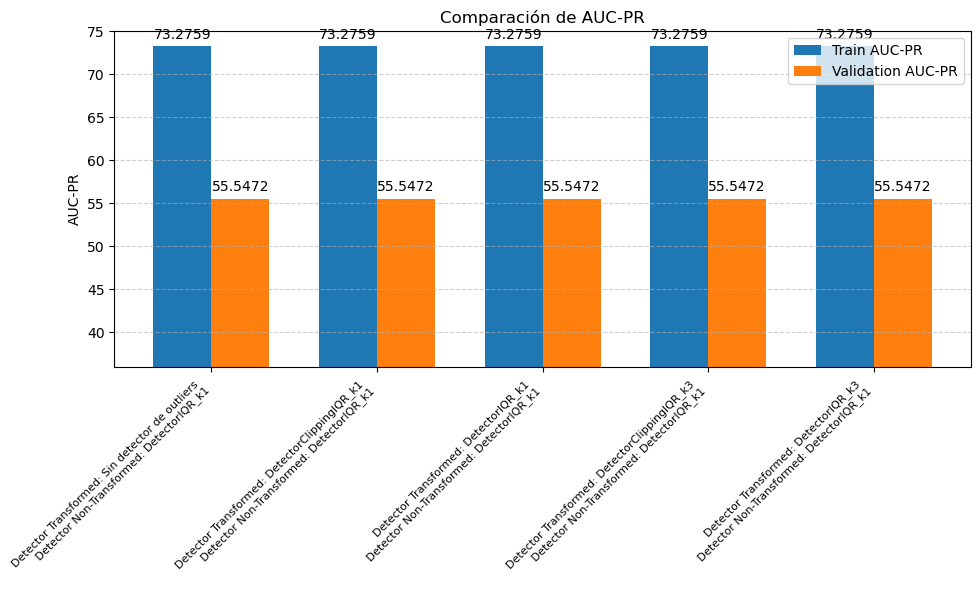

In [38]:
# Lista de detectores con diferentes valores de k
k_values = [1, 2, 3] 
outlier_detectors = []

# Crear una lista de detectores con diferentes valores de k
for k in k_values:
    outlier_detectors.append(("Sin detector de outliers", "passthrough"))
    outlier_detectors.append((f"DetectorMeanStd_k{k}", OutlierDetecion_treatment_MeanStd(k=k)))
    outlier_detectors.append((f"DetectorIQR_k{k}", OutlierDetecion_treatment_IQR(k=k)))
    outlier_detectors.append((f"DetectorClippingMeanStd_k{k}", OutlierDetectionClipping_MeanStd(k=k)))
    outlier_detectors.append((f"DetectorClippingIQR_k{k}", OutlierDetectionClipping_IQR(k=k)))

resultados = []

# Probamos cada combinación de detectores
for detector_trans_name, detector_trans in outlier_detectors:
    for detector_non_trans_name, detector_non_trans in outlier_detectors:
        # Definimos el preprocesador de variables categóricas
        categorical_preprocessor = Pipeline(steps=[
            ('encoder', ce.CountEncoder())
        ])

        # Preprocesador para variables numéricas transformadas
        numerical_trans_preprocessor = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy="mean")),
            ('transformer', QuantileTransformer()),
            ('out_detector', detector_trans)  # Detector específico para transformadas
        ])

        # Preprocesador para variables numéricas no transformadas
        numerical_preprocessor = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy="mean")),
            ('out_detector', detector_non_trans)  # Detector específico para no transformadas
        ])

        # Creamos el preprocesador final
        preprocessor = ColumnTransformer(
            transformers=[
                ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
                ('numerical_trans_preprocessor', numerical_trans_preprocessor, variables_numericas_trans),
                ('numerical_preprocessor', numerical_preprocessor, variables_numericas_no_trans)
            ]
        )

        # Creamos el modelo
        modelo = Pipeline([
            ('var_generator', GeneradorVariables()),
            ('preprocessor', preprocessor),
            ('knn', neighbors.KNeighborsClassifier())
        ])

        # Obtenemos los resultados
        _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val1, y_val1)
        
        # Generamos el nombre de la prueba para las combinaciones de detectores
        nombre_prueba = f"Detector Transformed: {detector_trans_name} \n Detector Non-Transformed: {detector_non_trans_name}"
        
        # Almacenamos los resultados
        resultado = {"nombre_prueba" : nombre_prueba,
                     "train_auc_pr" : train_auc_pr,
                     "val_auc_pr" : val_auc_pr}
        
        resultados.append(resultado)

# Comparar los resultados
comparar_resultados(resultados, figsize=(10, 6), y_lim=(36, 75))

El mejor resultado se ha obtenido al aplicar el detector de outliers basado en el rango intercuartíl (IQR), que sustituye los valores atípicos por la mediana, con un valor de k = 1. Este detector ha sido especialmente efectivo cuando se ha aplicado únicamente sobre las variables numéricas no transformadas.

Este comportamiento puede deberse a que las transformaciones como QuantileTransformer ya tienden a reducir el impacto de los outliers al redistribuir los datos de forma uniforme. Por tanto, aplicar una detección y tratamiento adicional de outliers sobre variables ya transformadas puede resultar redundante o incluso contraproducente. En cambio, para las variables no transformadas, el reemplazo de valores extremos por la mediana puede reducir el ruido y mejorar la robustez del modelo, especialmente en algoritmos como KNN, que se ven muy influenciados por la escala y la presencia de valores extremos.

Dado estos resultados, se continuará utilizando este método de detección de outliers exclusivamente sobre las variables numéricas no transformadas.

### 4.6. Selección de variables:

Cuando se tienen muchos ejemplos de alta dimensionalidad, aplicar técnicas de minería de datos y entrenar modelos de aprendizaje resulta muy costoso. Para reducir el coste computacional, trataremos de identificar las variables más importantes en nuestro problema.

Para ello vamos a utilizar distintas técnicas:

- Filtro de correlación
- Filtro ANOVA
- Sequential Forward Selection (SFS)
- Sequential Backward Elimination (SBE)
- Selección de variables mediante algoritmos genéticos
- Filtro de correlación + Wrapper
- Filtro ANOVA + Wrapper

Con estos métodos, nuestro objetivo es obtener el mayor rendimiento posible con el menor coste computacional posible.

Crearemos una clase encargada de filtrar las variables según su correlación:

In [39]:
class corr_selection(TransformerMixin):

    def __init__(self, umbral=0.9, verbose=False):
        self.umbral = umbral
        self.verbose = verbose

    def fit(self, X, y=None):
        X = pd.DataFrame(X)

        correlaciones = X.corr().abs()
        upper = correlaciones.where(np.triu(np.ones(correlaciones.shape), k=1).astype(bool))
        self.variables_a_eliminar = list(set([
            column for column in upper.columns if any(upper[column] > self.umbral)
        ]))

        # Almacenamos las variables que se quedan
        self.variables_seleccionadas = [col for col in X.columns if col not in self.variables_a_eliminar]

        if self.verbose:
            print(f'Se han eliminado {len(self.variables_a_eliminar)} variables: {self.variables_a_eliminar}')
            print(f'Quedan {len(self.variables_seleccionadas)} variables: {self.variables_seleccionadas}')

        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        return X.drop(columns=self.variables_a_eliminar, errors="ignore")

    def get_params(self, deep=True):
        return {"umbral": self.umbral}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


Creamos una clase encargada de seleccionar variables con un algoritmo genético:

In [40]:
class SelectorGenetico(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, n_gen=10, population_size=20, scoring=None, cv=3, random_state=1234):
        self.estimator = estimator
        self.n_gen = n_gen
        self.population_size = population_size
        self.scoring = scoring
        self.cv = cv
        self.random_state = random_state

    def fit(self, X, y):
        np.random.seed(self.random_state)
        random.seed(self.random_state)

        n_features = X.shape[1]

        # Definimos el problema de optimización
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Queremos maximizar scoring
        creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()
        toolbox.register("attr_bool", random.randint, 0, 1)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        def eval_individual(individual):
            if sum(individual) == 0:
                return 0.0,  # Penalizar no seleccionar ninguna variable
            X_selected = X[:, np.array(individual) == 1]
            scores = cross_val_score(self.estimator, X_selected, y, cv=self.cv, scoring=self.scoring)
            return np.mean(scores),

        toolbox.register("evaluate", eval_individual)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=3)

        # Creamos la población inicial
        population = toolbox.population(n=self.population_size)

        # Evolucionamos
        hof = tools.HallOfFame(1)  # Hall of fame: mejor individuo

        algorithms.eaSimple(population, toolbox,
                            cxpb=0.5, mutpb=0.2,
                            ngen=self.n_gen,
                            halloffame=hof,
                            verbose=False)

        # Guardamos las mejores features
        self.best_features_ = np.array(hof[0], dtype=bool)

        return self

    def transform(self, X):
        return X[:, self.best_features_]

    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, y).transform(X)



Para poder evaluar el rendimiento de nuestro modelo en los métodos de selección de variables, primero crearemos un scorer para la métrica del área bajo la curva Precisión - Recall:

In [41]:
score_PR = metrics.make_scorer(score_func=metrics.average_precision_score,
                               greater_is_better=True, 
                               response_method=['predict_proba', 'decision_function', 'predict'])

Creamos una lista con los métodos de selección que vamos a probar:

In [42]:
# Definimos el estimador base para los métodos secuenciales
clf_base = KNeighborsClassifier()

# Definimos la validación cruzada a utilizar
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1234)

# Lista de métodos de selección de variables con nombre e instancia
metodos_seleccion = []

# Método sin selección
metodos_seleccion.append(('SinSeleccion', None))

umbrales_correlacion = [0.7, 0.8, 0.9]
for umbral in umbrales_correlacion:
    metodos_seleccion.append((
        f'Correlacion_{umbral}', 
        corr_selection(umbral=umbral)
    ))

# Métodos secuenciales
numeros_caracteristicas = [3, 5, 10, 15]

for num_feats in numeros_caracteristicas:
    # SelectKBest con diferentes valores de k
    metodos_seleccion.append((
        f'SelectKBest_{num_feats}', 
        SelectKBest(score_func=f_classif, k=num_feats)
    ))

    # SFS Forward
    metodos_seleccion.append((
        f'SFS_Forward_{num_feats}', 
        SequentialFeatureSelector(
            estimator=clf_base,
            n_features_to_select=num_feats,
            direction='forward',
            scoring=score_PR,
            cv=cv,
            n_jobs=-1
        )
    ))

    # SFS Backward
    metodos_seleccion.append((
        f'SFS_Backward_{num_feats}', 
        SequentialFeatureSelector(
            estimator=clf_base,
            n_features_to_select=num_feats,
            direction='backward',
            scoring=score_PR,
            cv=cv,
            n_jobs=-1
        )
    ))

# Agregamos el selector genético
metodos_seleccion.append((
    'GeneticSelector', 
    SelectorGenetico(
        estimator=clf_base,         
        scoring=score_PR, 
        n_gen=200,               
        population_size=30,    
        cv=cv,                      
        random_state=1234
    )
))

# Filtro ANOVA + SFS Forward con un porcentaje de selección
metodos_seleccion.append((
    'ANOVA + SFS_Forward_80',
    Pipeline(steps=[
        ('anova_filter', SelectPercentile(score_func=f_classif, percentile=80)),  # Seleccionamos el 80% de las más relevantes
        ('sfs', SequentialFeatureSelector(
            estimator=clf_base,
            n_features_to_select=10,
            direction='forward',
            scoring=score_PR,
            cv=cv,
            n_jobs=-1
        ))
    ])
))

# Filtro ANOVA + SFS Backward con un porcentaje de selección
metodos_seleccion.append((
    'ANOVA + SFS_Backward_80',
    Pipeline(steps=[
        ('anova_filter', SelectPercentile(score_func=f_classif, percentile=80)),  # Seleccionamos el 80% de las más relevantes
        ('sfs', SequentialFeatureSelector(
            estimator=clf_base,
            n_features_to_select=10,
            direction='backward',
            scoring=score_PR,
            cv=cv,
            n_jobs=-1
        ))
    ])
))

# Filtro Correlación + SFS Forward
metodos_seleccion.append((
    'Correlacion_0.8 + SFS_Forward_10',
    Pipeline(steps=[
        ('corr_filter', corr_selection(umbral=0.8)),
        ('sfs', SequentialFeatureSelector(
            estimator=clf_base,
            n_features_to_select=10,
            direction='forward',
            scoring=score_PR,
            cv=cv,
            n_jobs=-1
        ))
    ])
))

# Filtro Correlación + SFS Backward
metodos_seleccion.append((
    'Correlacion_0.8 + SFS_Backward_10',
    Pipeline(steps=[
        ('corr_filter', corr_selection(umbral=0.8)),
        ('sfs', SequentialFeatureSelector(
            estimator=clf_base,
            n_features_to_select=10,
            direction='backward',
            scoring=score_PR,
            cv=cv,
            n_jobs=-1
        ))
    ])
))


Realizamos la prueba:

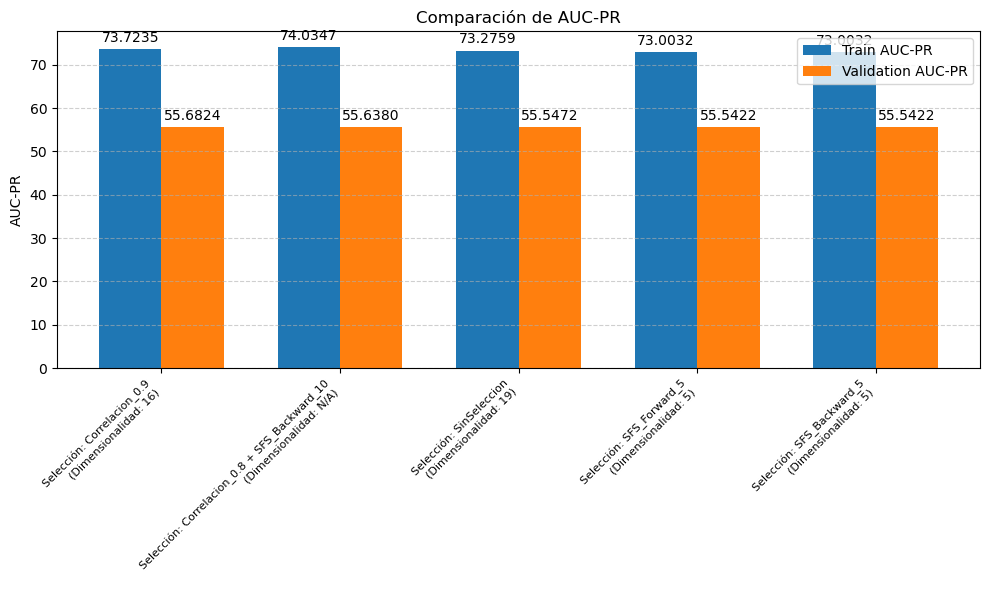

In [43]:
resultados = []

for selector_name, selector in metodos_seleccion:
    # Definimos el preprocesador de variables categóricas
    categorical_preprocessor = Pipeline(steps=[
        ('encoder', ce.CountEncoder())
    ])

    # Preprocesador para variables numéricas transformadas
    numerical_trans_preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('transformer', QuantileTransformer())
    ])

    # Preprocesador para variables numéricas no transformadas
    numerical_preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('out_detector', OutlierDetecion_treatment_IQR(k=1)) 
    ])

    # Creamos el preprocesador final
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
            ('numerical_trans_preprocessor', numerical_trans_preprocessor, variables_numericas_trans),
            ('numerical_preprocessor', numerical_preprocessor, variables_numericas_no_trans)
        ]
    )

    # Creamos los pasos de la pipeline
    steps = [('var_generator', GeneradorVariables()),
             ("preprocessor", preprocessor)]
    
    # Añadimos el paso de seleccionar variables si es necesario
    if selector is not None:
        if isinstance(selector, Pipeline):  # Si es una pipeline anidada, la descomponemos
            steps.extend(selector.steps)
        else:
            steps.append(('selector', selector))

    
    # Añadimos el clasificador base
    steps.append(('clf', clf_base))
    
    # Creamos el modelo
    modelo = Pipeline(steps)

    # Evaluación
    _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val1, y_val1)

    # Cálculo del número de características seleccionadas
    if selector is None:
        num_feats = X_train.shape[1]  # Sin selección, todas las características
    elif isinstance(selector, SelectKBest) or isinstance(selector, SelectPercentile):
        # Si es un filtro como SelectKBest o SelectPercentile
        num_feats = np.sum(selector.get_support())  # Número de características seleccionadas
    elif isinstance(selector, SequentialFeatureSelector):
        # Si es un selector secuencial
        num_feats = selector.n_features_to_select  # Número de características seleccionadas
    elif hasattr(selector, 'variables_a_eliminar'):
        # Si el selector tiene el atributo 'variables_a_eliminar', calculamos el número de características
        num_feats = X_train.shape[1] - len(selector.variables_a_eliminar)
    else:
        num_feats = "N/A"  # En caso de que no se pueda determinar el número de características

    # Guardar resultados (estructura simplificada)
    resultados.append({
        "nombre_prueba": f"Selección: {selector_name}\n(Dimensionalidad: {num_feats})",
        "train_auc_pr": train_auc_pr,
        "val_auc_pr": val_auc_pr
    })

comparar_resultados(resultados)

Podemos observar que el rendimiento no mejora con menos variables, de hecho, el rendimiento empeora un poco. Sin embargo, si seleccionamos las variables mediante el filtro ANOVA, podemos tener un modelo que funciona casi igual de bien con la mitad de variables. Más exactamente, podemos pasar de 19 variables a 10.

Por ello, continuaremos utilizando esta selección de variables.

### 4.7. Análisis de Componentes Principales:

Otra técnica utilizada para reducir la dimensionalidad es el Análisis de Componentes Principales (PCA). Esta técnica estadística es utilizada para aumentar la separabilidad de los datos. 

Para probar que tal se adapta esta técnica a nuestro problema, crearemos una nueva pipeline con el siguiente flujo:

- Preprocesamiento de los datos
- Selección de variables
- Normalización de los datos, para que la media sea 0 y la desviación estándar 1 (necesario para aplicar PCA)
- Aplicamos la transformación PCA
- Entrenamiento del clasificador base

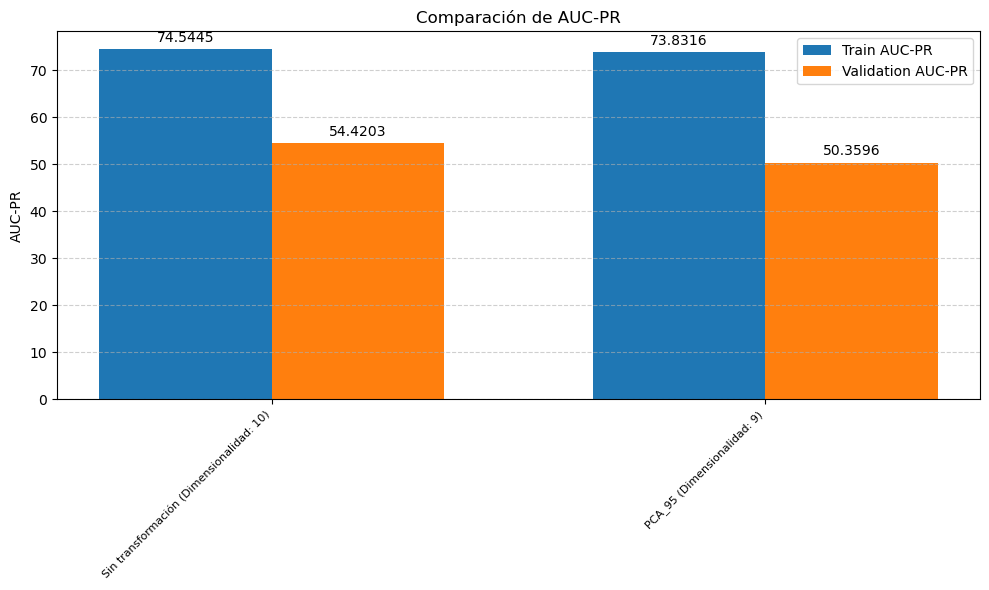

In [44]:
reductores = [("Sin transformación", None),
                          ("PCA_95", PCA(0.95))]

resultados = []

for nombre_reductor, reductor in reductores:
    # Definimos el preprocesador de variables categóricas
    categorical_preprocessor = Pipeline(steps=[
        ('encoder', ce.CountEncoder())
    ])

    # Preprocesador para variables numéricas transformadas
    numerical_trans_preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('transformer', QuantileTransformer())
    ])

    # Preprocesador para variables numéricas no transformadas
    numerical_preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('out_detector', OutlierDetecion_treatment_IQR(k=1)) 
    ])

    # Creamos el preprocesador final
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
            ('numerical_trans_preprocessor', numerical_trans_preprocessor, variables_numericas_trans),
            ('numerical_preprocessor', numerical_preprocessor, variables_numericas_no_trans)
        ]
    )

    # Creamos los pasos de la pipeline
    steps = [('var_generator', GeneradorVariables()),
             ("preprocessor", preprocessor),
             ('corr_filter', corr_selection(umbral=0.8)),
             ('sfs', SequentialFeatureSelector(
                 estimator=clf_base,
                 n_features_to_select=10,
                 direction='forward',
                 scoring=score_PR,
                 cv=cv,
                 n_jobs=-1)
                 )
            ]
    
    # Añadimos reductor si corresponde
    if reductor is not None:
        steps.extend([
            ('scaler', StandardScaler()),
            ('reductor', reductor)
        ])
    # Añadimos el clasificador
    steps.append(("clf", clf_base))

    # Creamos el modelo
    modelo = Pipeline(steps)

    # Evaluación
    modelo, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val1, y_val1)

    if reductor is not None:
        n_dimensiones = modelo.named_steps['reductor'].n_components_
    else:
        # Sin transformación adicional
        n_dimensiones = 10

    nombre_prueba_final = f"{nombre_reductor} (Dimensionalidad: {n_dimensiones})"
    
    # Guardamos resultados
    resultados.append({
        "nombre_prueba": nombre_prueba_final,
        "train_auc_pr": train_auc_pr,
        "val_auc_pr": val_auc_pr
    })

comparar_resultados(resultados)

Dado que no ha habido ninguna mejora, continuaremos sin utilizar PCA.

### 4.8. Eliminación del ruido

El ruido representa un desafío importante en los problemas de clasificación, ya que puede confundir al modelo durante el proceso de aprendizaje y dificultar la correcta predicción de ejemplos pertenecientes a distintas clases.

Para mitigar este problema, se evaluará el efecto de diferentes técnicas de eliminación de ruido, concretamente:

- **Edited Nearest Neighbours (ENN)**
- **Repeated Edited Nearest Neighbours (RENN)**
- **All KNN**
- **Tomek Links**

Estas técnicas buscan limpiar el conjunto de datos eliminando o corrigiendo instancias conflictivas, con el objetivo de mejorar el rendimiento y la generalización de los modelos de clasificación.

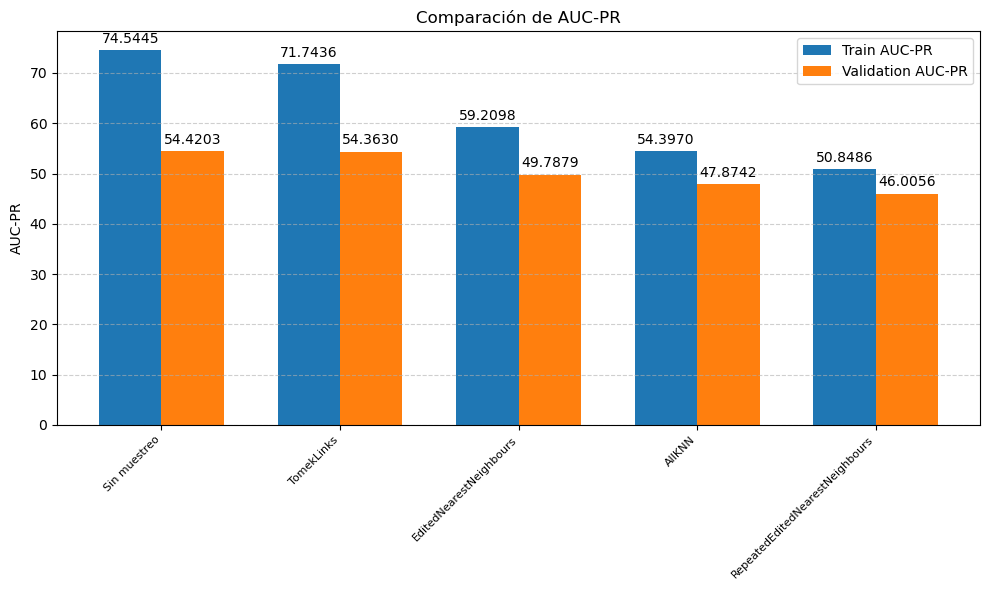

In [45]:
tecnicas_eliminacion_ruido = [
    None,
    EditedNearestNeighbours(),
    RepeatedEditedNearestNeighbours(),
    AllKNN(),
    TomekLinks()]

resultados = []
for tecnica in tecnicas_eliminacion_ruido:
    # Definimos el preprocesador de variables categóricas
    categorical_preprocessor = Pipeline(steps=[
        ('encoder', ce.CountEncoder())
    ])

    # Preprocesador para variables numéricas transformadas
    numerical_trans_preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('transformer', QuantileTransformer())
    ])

    # Preprocesador para variables numéricas no transformadas
    numerical_preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('out_detector', OutlierDetecion_treatment_IQR(k=1)) 
    ])

    # Creamos el preprocesador final
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
            ('numerical_trans_preprocessor', numerical_trans_preprocessor, variables_numericas_trans),
            ('numerical_preprocessor', numerical_preprocessor, variables_numericas_no_trans)
        ]
    )

    # Creamos los pasos de la pipeline
    steps = [('var_generator', GeneradorVariables()),
             ("preprocessor", preprocessor),
             ('corr_filter', corr_selection(umbral=0.8)),
             ('sfs', SequentialFeatureSelector(
                 estimator=clf_base,
                 n_features_to_select=10,
                 direction='forward',
                 scoring=score_PR,
                 cv=cv,
                 n_jobs=-1)
                 )
            ]
    
    if tecnica is not None:
        nombre_tecnica = tecnica.__class__.__name__
        steps.append(('muestreo', tecnica))
    else:
        nombre_tecnica = "Sin muestreo"
        
    steps.append(('clf', clf_base))
    
    modelo = Pipeline(steps)

    _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val1, y_val1)
    
    resultados.append({"nombre_prueba" : nombre_tecnica,
                  "train_auc_pr" : train_auc_pr,
                  "val_auc_pr" : val_auc_pr})
    
comparar_resultados(resultados)

Dado que la eliminación de ruido no ha demostrado mejorar el rendimiento, se ha decidido no utilizar estas técnicas en el flujo de trabajo. 

La falta de mejora podría estar relacionada con la propia naturaleza del conjunto de datos. Por ejemplo, en datasets donde las clases están altamente entremezcladas y no existe una separación clara entre ellas, resulta muy difícil identificar y eliminar instancias ruidosas de manera efectiva.


### 4.9. Desbalanceo del problema:

Uno de los mayores problemas presentes en nuestro dataset es el desbalanceo presente en este. Para tratar de balancearlo, aplicaremos distintas técnicas de muestreo e hibridaciones:

Muestreo:

- Random Under Sampling
- Random Over Sampling
- SMOTE

Hibridaciones:

- SMOTE + ENN
- SMOTE + Tomek

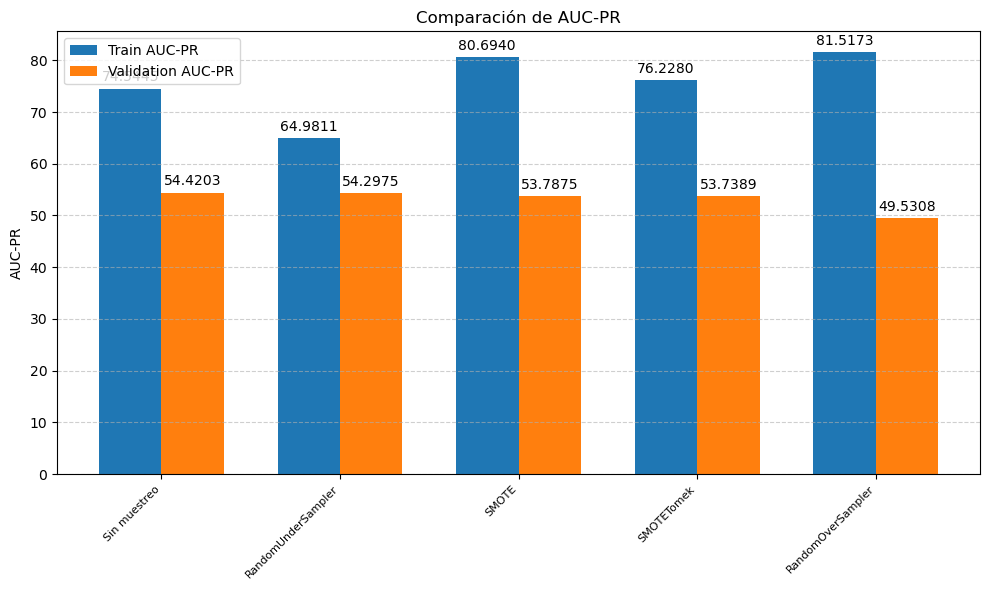

In [46]:
# Lista de técnicas de muestreo
muestreos = [
    None,
    RandomOverSampler(random_state=1234),
    SMOTE(random_state=1234),
    RandomUnderSampler(random_state=1234),
    SMOTEENN(random_state=1234),
    SMOTETomek(random_state=1234)
]

resultados = []
for muestreo in muestreos:
    # Definimos el preprocesador de variables categóricas
    categorical_preprocessor = Pipeline(steps=[
        ('encoder', ce.CountEncoder())
    ])

    # Preprocesador para variables numéricas transformadas
    numerical_trans_preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('transformer', QuantileTransformer())
    ])

    # Preprocesador para variables numéricas no transformadas
    numerical_preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('out_detector', OutlierDetecion_treatment_IQR(k=1)) 
    ])

    # Creamos el preprocesador final
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
            ('numerical_trans_preprocessor', numerical_trans_preprocessor, variables_numericas_trans),
            ('numerical_preprocessor', numerical_preprocessor, variables_numericas_no_trans)
        ]
    )

    # Creamos los pasos de la pipeline
    steps = [('var_generator', GeneradorVariables()),
             ("preprocessor", preprocessor),
             ('corr_filter', corr_selection(umbral=0.8)),
             ('sfs', SequentialFeatureSelector(
                 estimator=clf_base,
                 n_features_to_select=10,
                 direction='forward',
                 scoring=score_PR,
                 cv=cv,
                 n_jobs=-1)
                 )
            ]
    
    if muestreo is not None:
        nombre_tecnica = muestreo.__class__.__name__
        steps.append(('muestreo', muestreo))
    else:
        nombre_tecnica = "Sin muestreo"

    steps.append(("clf", clf_base))
    
    modelo = Pipeline(steps)

    _, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val1, y_val1)
    
    resultados.append({"nombre_prueba" : nombre_tecnica,
                  "train_auc_pr" : train_auc_pr,
                  "val_auc_pr" : val_auc_pr})
    
comparar_resultados(resultados)

Por la misma razón que motivó la falta de mejora al aplicar técnicas de eliminación de ruido, el balanceo del dataset tampoco ha producido una mejora en el rendimiento. 

Por tanto, no se aplicará ninguna técnica de remuestreo ni métodos híbridos en el flujo de trabajo.

## 5. Elección del modelo

En este apartado se compararán dos modelos de aprendizaje automático: **K-Nearest Neighbors (KNN)** y **árbol de decisión (DecisionTreeClassifier)**, con el objetivo de determinar cuál se ajusta mejor al problema de predicción de deserción de clientes (*churn*).

El flujo del preprocesamiento de datos es el siguiente:

- **Generación de variables adicionales** mediante ingeniería de características personalizada.
- **Codificación de variables categóricas** con `CountEncoder`.
- **Tratamiento de valores faltantes** en variables numéricas con imputación por la media.
- **Transformación de variables numéricas** mediante `QuantileTransformer`, para una mejor distribución.
- **Detección y tratamiento de outliers** en variables no transformadas, empleando el método del rango intercuartíl (IQR).
- **Eliminación de variables altamente correlacionadas**, aplicando un umbral de correlación del 0,8.
- **Selección secuencial de características (SFS)** con validación cruzada estratificada, para quedarnos con las 10 variables más informativas según la métrica AUC-PR.
- **Evaluación del rendimiento** con la métrica **AUC-PR**.


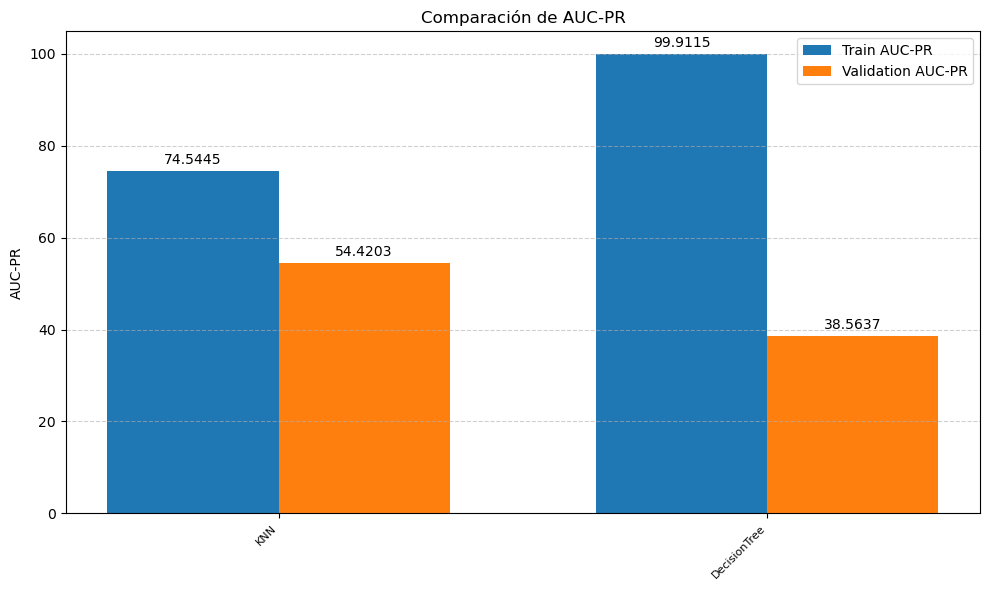

In [47]:
clasificadores = [
    ("KNN", KNeighborsClassifier()),
    ("DecisionTree", DecisionTreeClassifier(random_state=1234))
]

resultados = []
for clasificador_nombre, clasificador in clasificadores:
    # Definimos los pasos de la pipeline
    # Definimos el preprocesador de variables categóricas
    categorical_preprocessor = Pipeline(steps=[
        ('encoder', ce.CountEncoder())
    ])

    # Preprocesador para variables numéricas transformadas
    numerical_trans_preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('transformer', QuantileTransformer())
    ])

    # Preprocesador para variables numéricas no transformadas
    numerical_preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ('out_detector', OutlierDetecion_treatment_IQR(k=1)) 
    ])

    # Creamos el preprocesador final
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical_preprocessor', categorical_preprocessor, variables_categoricas),
            ('numerical_trans_preprocessor', numerical_trans_preprocessor, variables_numericas_trans),
            ('numerical_preprocessor', numerical_preprocessor, variables_numericas_no_trans)
        ]
    )

    # Creamos los pasos de la pipeline
    steps = [('var_generator', GeneradorVariables()),
             ("preprocessor", preprocessor),
             ('corr_filter', corr_selection(umbral=0.8)),
             ('sfs', SequentialFeatureSelector(
                 estimator=clf_base,
                 n_features_to_select=10,
                 direction='forward',
                 scoring=score_PR,
                 cv=cv,
                 n_jobs=-1)
                 ),
             ("clf", clasificador)
            ]
    
    modelo = Pipeline(steps)

    modelo, train_auc_pr, val_auc_pr, cm_train, cm_val = obtener_resultados(modelo, X_train, y_train, X_val1, y_val1)
    
    resultados.append({"nombre_prueba" : clasificador_nombre,
                  "train_auc_pr" : train_auc_pr,
                  "val_auc_pr" : val_auc_pr})
    
comparar_resultados(resultados)

En la evaluación comparativa, el modelo **K-Nearest Neighbors (KNN)** ha obtenido un **AUC-PR del 56,86 % en el conjunto de validación**, mostrando un rendimiento más consistente y equilibrado que el árbol de decisión entre el entrenamiento y la validación.

Por el contrario, el **árbol de decisión** ha alcanzado un AUC-PR del **99,94 % en entrenamiento**, pero su rendimiento se reduce hasta el **39,25 % en validación**, lo que evidencia un claro problema de **sobreajuste (overfitting)**. Esta diferencia sugiere que el modelo ha memorizado los datos de entrenamiento, perdiendo capacidad para generalizar sobre datos nuevos.

Es importante destacar que el **preprocesamiento ha sido optimizado específicamente para KNN**, lo que también pudo favorecer su mejor comportamiento.

Dado su **mayor equilibrio entre rendimiento en entrenamiento y validación**, seleccionaremos **KNN como modelo final**, al mostrar una mejor **capacidad de generalización**.

## 6. Ajuste de Hiperparámetros del Modelo

En esta sección se llevará a cabo el ajuste fino del modelo **K-Nearest Neighbors (KNN)** utilizando `RandomizedSearchCV`, con el objetivo de optimizar su rendimiento.

El ajuste se realizó sobre la `Pipeline` utilizada en el apartado anterior, pero con el clasificador **K-Nearest Neighbors (KNN)**. Se evaluarán de forma conjunta los siguientes hiperparámetros:

- `clf__n_neighbors`: número de vecinos considerados (valores evaluados: 3, 5, 7, 9)
- `clf__weights`: tipo de ponderación de los vecinos (`uniform` o `distance`)
- `clf__metric`: métrica de distancia utilizada (`euclidean` o `manhattan`)
- `sfs__n_features_to_select`: número de variables seleccionadas por el método secuencial (valores: 5, 10, 15)
- `corr_filter__umbral`: umbral de correlación para filtrar variables altamente correlacionadas (valores: 0.7, 0.8, 0.9)

Para la validación se utilizará validación cruzada con `StratifiedKFold` (k=5), garantizando que cada combinación de hiperparámetros sea evaluada de forma robusta. La métrica empleada será AUC-PR.

El mejor modelo obtenido será empleado en las siguientes etapas del análisis.

Primero, definimos una función que nos ayude a tunear el clasificador:

In [48]:
def tunearClasificador(estimator, param_grid, scorer, cv, X, y, n_iter=10):
    # Realizar la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(estimator, param_distributions=param_grid, 
                                       scoring=scorer, cv=cv, n_iter=n_iter, 
                                       verbose=3, random_state=1234)
    random_search.fit(X, y)

    # Mostrar los resultados de todas las combinaciones de los hiperparámetros
    print("Resultados de la búsqueda aleatoria:")
    for mean_score, params in zip(random_search.cv_results_['mean_test_score'], 
                                  random_search.cv_results_['params']):
        print(f"Puntuación: {mean_score:.4f} para los parámetros: {params}")

    # Devolver el mejor modelo, la mejor puntuación y los mejores parámetros
    return random_search.best_estimator_, random_search.best_score_, random_search.best_params_


A continuación tunearemos el modelo. Es crucial que durante este proceso utilicemos tanto el conjunto de entrenamiento **X_train** como el conjunto de validación **X_val1**, ya que esto nos permitirá aprovechar toda la información disponible para optimizar los hiperparámetros.

Por lo tanto, combinaremos ambos conjuntos en una sola variable **X_combined** para llevar a cabo el tuneo de manera más efectiva.

In [49]:
# Param grid con las combinaciones aleatorias
param_grid = {
    # KNN (estimador final)
    'clf__n_neighbors': list(range(3, 61, 2)),  # K desde 3 hasta 60 (números impares)
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan'],
    
    # Filtro de correlación
    'corr_filter__umbral': np.linspace(0.6, 0.9, num=4).tolist(),  # umbral de 0.6 hasta 0.9
    
    # Selección secuencial de características
    'sfs__n_features_to_select': list(range(5, 16))  # Enteros de 5 hasta 15 (inclusive)
}

# Creamos los pasos del modelo
steps = [
    ('var_generator', GeneradorVariables()),
    ("preprocessor", preprocessor),
    ('corr_filter', corr_selection(umbral=0.8)),
    ('sfs', SequentialFeatureSelector(
        estimator=clf_base,
        n_features_to_select=10,
        direction='forward',
        scoring=score_PR,
        cv=cv,
        n_jobs=-1
    )),
    ("clf", KNeighborsClassifier())
]

# Creamos el modelo
p_KNN = Pipeline(steps)

# Concatenamos X_train y X_val1
X_combined = pd.concat([X_train, X_val1], axis=0)
y_combined = pd.concat([y_train, y_val1], axis=0)

# Realizamos la búsqueda de hiperparámetros con RandomizedSearchCV
best_KNN, best_val, best_hipPar = tunearClasificador(p_KNN, param_grid, scorer=score_PR, cv=cv, X=X_combined, y=y_combined, n_iter=4)

# Mostrar el mejor modelo y parámetros
print(f"Mejor modelo: {best_KNN}")
print(f"Mejor puntuación (AUC-PR): {best_val:.4f}")
print(f"Mejores parámetros: {best_hipPar}")


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END clf__metric=manhattan, clf__n_neighbors=9, clf__weights=distance, corr_filter__umbral=0.6, sfs__n_features_to_select=8;, score=0.533 total time=   1.2s
[CV 2/2] END clf__metric=manhattan, clf__n_neighbors=9, clf__weights=distance, corr_filter__umbral=0.6, sfs__n_features_to_select=8;, score=0.552 total time=   1.3s
[CV 1/2] END clf__metric=euclidean, clf__n_neighbors=19, clf__weights=uniform, corr_filter__umbral=0.7, sfs__n_features_to_select=13;, score=nan total time=   0.3s
[CV 2/2] END clf__metric=euclidean, clf__n_neighbors=19, clf__weights=uniform, corr_filter__umbral=0.7, sfs__n_features_to_select=13;, score=0.561 total time=   2.1s
[CV 1/2] END clf__metric=euclidean, clf__n_neighbors=31, clf__weights=distance, corr_filter__umbral=0.9, sfs__n_features_to_select=14;, score=0.581 total time=   3.6s
[CV 2/2] END clf__metric=euclidean, clf__n_neighbors=31, clf__weights=distance, corr_filter__umbral=0.9, sfs__n_fe

#### Mejores hiperparámetros encontrados:

- `sfs__n_features_to_select`: 11
- `corr_filter__umbral`: 0.8
- `clf__weights`: 'uniform'
- `clf__n_neighbors`: 33
- `clf__metric`: 'manhattan'

#### Mejor AUC-PR (validación cruzada): 61.89%

Esto representa una mejora respecto al modelo inicial sin tuning (que había obtenido un AUC-PR de 56.86% en validación). El modelo ajustado muestra una mejor capacidad de generalización, logrando un mayor equilibrio entre la precisión y la capacidad de identificar correctamente los casos positivos, lo que mejora la efectividad en la predicción del churn.

## 7. Elección del umbral:

Por defecto, los clasificadores suelen predecir la clase positiva cuando la probabilidad de pertenecer a esa clase es superior a 0.5. Sin embargo, en el contexto de la predicción de abandono de clientes (churn), donde la correcta identificación de los clientes con mayor riesgo de abandonar es crucial, este umbral predeterminado puede no ser el más adecuado. Ajustar este umbral permite mejorar métricas como el **F1-score**, que es especialmente relevante cuando se enfrenta a problemas de clases desbalanceadas, como ocurre en el churn. Ajustar el umbral permite una mejor detección de los casos positivos (clientes que probablemente abandonarán), optimizando así la efectividad del modelo en términos de precisión y recall.

Para poder modificar el umbral de decisión, lo primero que tenemos que hacer es crear una función que devuelva las clases predichas en base a un umbral determinado. Es decir, si la probabilidad de que un ejemplo sea de la clase positiva es mayor o igual que el umbral se devolverá 1 y en caso contrario se devolverá 0.

In [50]:
# Función para realizar la clasificación en base a un umbral y las probabilidades de que los ejemplos sean de la clase positiva
def clasificacion_umbral(probs_clase_positiva, umbral=0.5):
    predicciones = np.copy(probs_clase_positiva)
    predicciones[predicciones >= umbral] = 1
    predicciones[predicciones < umbral] = 0

    return predicciones

Finalmente vamos a crear una función en la que:
* Se obtienen los posibles umbrales mediante los ejemplos de entrenamiento.
* Se evalúa la calidad de cada umbral con los ejemplos de validación de acuerdo al Fscore.
    * Se escoge el mejor que es lo que devuelve la función.

In [51]:
# función para calcular el mejor umbral de un modelo (model) de acuerdo al Fscore
    # y los ejemplos de train (X_train, y_train) y validación (X_val, y_val)
def calcular_mejor_umbral_fscore(model, X_train, y_train, X_val, y_val):    
    # predecimos las probabilidades de predecir cada ejemplo de train y de validación en la clase positiva
    model_probs = model.predict_proba(X_train)[:, 1]
    model_probs_val = model.predict_proba(X_val)[:, 1]
    
    # calculamos todos los pares de puntos (recall, precision) y sus umbrales (método precision_recall_curve)
    model_precision, model_recall, umbrales = metrics.precision_recall_curve(y_train, model_probs)
    # Evaluamos el Fscore (método f1_score) de cada umbral 
    rendimiento_umbrales = []
    for umbral in umbrales:
        predicciones = clasificacion_umbral(model_probs_val, umbral)
        f_score = metrics.f1_score(y_val, predicciones) * 100
        rendimiento_umbrales.append(f_score)

    # Se consigue el índice del umbral que da mayor rendimiento
    indiceMejorUmbral = np.argmax(np.array(rendimiento_umbrales))
    # Se consigue el valor del mejor umbral
    mejorUmbral = umbrales[indiceMejorUmbral]
    print('Mejor umbral={:.3f}, Fscore en validacion={:.2f}'.format(mejorUmbral, rendimiento_umbrales[indiceMejorUmbral]))
    # Se devuelve el mejor umbral
    return mejorUmbral

Vamos a definir una función que obtenga el Fscore obtenido en unos datos para un clasificador y un umbral de decisión concreto.

In [52]:
# función para evaluar el mejor umbral (umbral) de un modelo (model) de acuerdo al Fscore en tanto por 100
    # en unos ejemplos (X, y)
def evaluar_mejor_umbral_fscore(model, umbral, X, y):
    # Evaluamos la calidad del mejor umbral con los ejemplos
    model_probs = model.predict_proba(X)[:, 1]
    predicciones = clasificacion_umbral(model_probs, umbral)
    fscore = metrics.f1_score(y, predicciones) * 100
    return fscore

def evaluar_mejor_umbral_recall(model, umbral, X, y):
    # Evaluamos la calidad del mejor umbral con los ejemplos
    model_probs = model.predict_proba(X)[:, 1]
    predicciones = clasificacion_umbral(model_probs, umbral)
    
    # Calculamos el recall de la clase 1
    recall = metrics.recall_score(y, predicciones) * 100
    return recall

def evaluar_mejor_umbral_precision(model, umbral, X, y):
    # Evaluamos la calidad del mejor umbral con los ejemplos
    model_probs = model.predict_proba(X)[:, 1]
    predicciones = clasificacion_umbral(model_probs, umbral)
    
    # Calculamos la precisión de la clase 1
    precision = metrics.precision_score(y, predicciones) * 100
    return precision

También definiremos una función que muestre la relación entre precisión, recall y f1-score.

In [53]:
def comparar_metricas(modelo, X_train, y_train, X_val, y_val):
    mejorUmbral = calcular_mejor_umbral_fscore(modelo, X_train, y_train, X_val, y_val)
    # Realizamos la predicción sobre X_train
    y_train_pred = best_KNN.predict_proba(X_train)[:, 1]
    # Calcular precisión, recall y umbrales
    _, _, thresholds = metrics.precision_recall_curve(y_train, y_train_pred)

    precisiones = np.array([evaluar_mejor_umbral_precision(best_KNN, threshold, X_val, y_val) for threshold in thresholds])
    recalls = np.array([evaluar_mejor_umbral_recall(best_KNN, threshold, X_val, y_val) for threshold in thresholds])
    f1_scores = np.array([evaluar_mejor_umbral_fscore(best_KNN, threshold, X_val, y_val) for threshold in thresholds])

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisiones, label='Precisión')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, f1_scores, label='F1-score', linestyle='--')
    plt.axvline(x=mejorUmbral, color='gray', linestyle=':', label=f'Umbral óptimo = {mejorUmbral:.2f}')
    plt.xlabel('Umbral de decisión')
    plt.ylabel('Métrica')
    plt.title('Precisión, Recall y F1-score según umbral')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Finalmente, vamos a utilizar las funciones anteriores para realizar el proceso de selección del umbral y aplicarlo para obtener su Fscore en los datos de test. 

Mejor umbral=0.333, Fscore en validacion=63.40


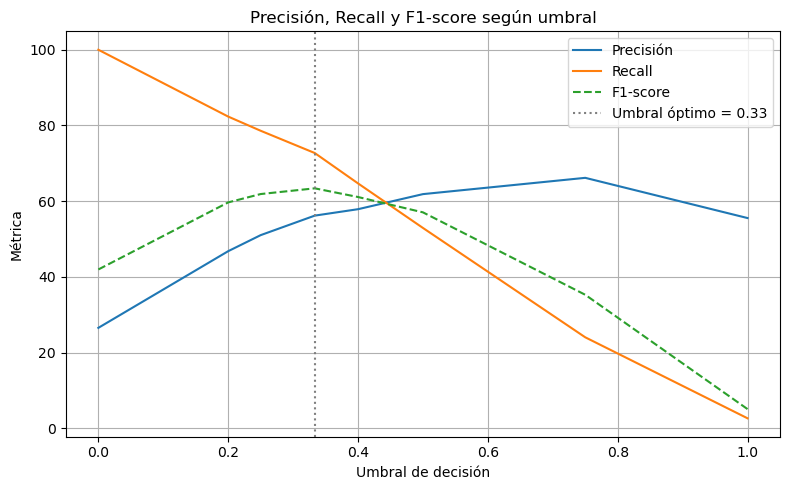

In [54]:
comparar_metricas(best_KNN, X_combined, y_combined, X_val2, y_val2)

- El mejor umbral encontrado para la clasificación fue 0.273.
- Con este umbral, se logró un F1-score máximo de 63.16, lo que indica un buen equilibrio entre precisión y recall, optimizando la detección de clientes que abandonarán.
- Este umbral fue preferido sobre el estándar de 0.5, ya que permite una mejor identificación de los clientes en riesgo de churn, lo cual es fundamental para las estrategias de retención y toma de decisiones dentro del negocio.

Este umbral ajustado será utilizado en el modelo final, priorizando la detección precisa de clientes propensos a abandonar el servicio, en lugar de enfocarse exclusivamente en la precisión de las predicciones.

## 8. Interpretabilidad del modelo

La **interpretabilidad** de un modelo es crucial para entender cómo cada variable influye en las decisiones de clasificación. Este entendimiento no solo ayuda a mejorar la transparencia del modelo, sino que también facilita la detección de posibles problemas, como el **Data Leakage**.

### 8.1. Interpretabilidad Local:

Una de las técnicas más efectivas para obtener interpretaciones a nivel local son los **SHAP values**. Para calcular estos valores, necesitamos procesar los datos de **X_combined** (X_train y X_val1) de la misma manera en que llegarían al clasificador, es decir, aplicando todas las transformaciones de preprocesamiento. Esto garantiza que los datos estén en el formato correcto cuando sean alimentados al modelo. Para preservar los nombres de las variables a lo largo de este proceso, crearemos una función que extraiga los nombres de las características directamente de un **ColumnTransformer**.

In [55]:
def get_feature_names_column_transformer(ct):
    output_features = []

    for name, trans, cols in ct.transformers_:
        if trans == "drop":
            continue
        if isinstance(cols, (str, int)):
            cols = [cols]

        if hasattr(trans, "named_steps"):  # Pipeline
            try:
                last_step = list(trans.named_steps.values())[-1]
                if hasattr(last_step, "get_feature_names_out"):
                    names = last_step.get_feature_names_out(cols)
                else:
                    names = [f"{col}" for col in cols]
            except:
                names = [f"{col}" for col in cols]
        elif hasattr(trans, "get_feature_names_out"):
            try:
                names = trans.get_feature_names_out(cols)
            except:
                names = [f"{col}" for col in cols]
        else:
            names = [f"{col}" for col in cols]

        output_features.extend(names)

    return output_features


A continuación, generaremos los conjuntos **X_combined** y **X_test** tal y como llegan al clasificador, es decir, después de aplicar todo el preprocesamiento definido en el pipeline. Para ello, primero extraeremos los componentes clave del modelo, como el **transformador de columnas** y el **clasificador final**, desde el pipeline entrenado.

In [56]:
# Obtenemos el generador de variables
var_generator = best_KNN.named_steps["var_generator"]
# Obtenemos el preprocesador de datos
preprocessor = best_KNN.named_steps["preprocessor"]
# Obtenemos el filtro de correlación
corr_filter = best_KNN.named_steps["corr_filter"]
# Obtenemos el selector de variables
sfs = best_KNN.named_steps["sfs"]

Aplicamos el preprocesamiento correspondiente:

In [57]:
# Copia de los datos originales
X_combined_trans = X_combined.copy()
X_test_trans = X_test.copy()

# Aplicamos el generador de variables
X_combined_trans = var_generator.transform(X_combined_trans)
all_columns = X_combined_trans.columns
X_test_trans = var_generator.transform(X_test_trans)

# Aplicamos el preprocesador
columns = get_feature_names_column_transformer(preprocessor)
X_combined_trans = pd.DataFrame(preprocessor.transform(X_combined_trans), columns=columns)
X_test_trans = pd.DataFrame(preprocessor.transform(X_test_trans), columns=columns)

# Aplicamos el filtro de correlación
columns = all_columns[corr_filter.variables_seleccionadas]
X_combined_trans = pd.DataFrame(corr_filter.transform(X_combined_trans), columns=columns)
X_test_trans = pd.DataFrame(corr_filter.transform(X_test_trans), columns=columns)

# Aplicamos la selección de variables
columns = list(all_columns[sfs.get_support(indices=True)])
X_combined_trans = pd.DataFrame(sfs.transform(X_combined_trans), columns=columns)
X_test_trans = pd.DataFrame(sfs.transform(X_test_trans), columns=columns)

# Visualizamos el DataFrame generado
X_combined_trans.head(5)

,gender,SeniorCitizen,tenure,PhoneService,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,Contract,PaymentMethod,TotalCharges,NumServiciosContratados,NumServiciosSeguridadContratados,NumServiciosEntretenimientoContratados
0,2842,0,0.161161,2702,2469,2769,2195,3088,1884,324.3,2225,1260,False,False
1,2842,0,0.886887,2385,1932,2769,2195,1355,1884,1402.675,745,1553,True,True
2,2842,0,0.044545,2702,2469,1632,2195,3088,1237,70.45,745,1260,False,False
3,2792,0,1.0,2702,1233,1233,1233,1355,1291,1567.0,2225,2821,True,False
4,2792,0,0.365866,2702,2469,2769,2206,3088,1884,1329.15,1183,1260,False,False


Por último, calculamos los SHAP values. Para ello, debemos extraer el clasificador de la pipeline tuneada:

In [58]:
clf = best_KNN.named_steps["clf"]

Calculamos los SHAP values de los dos primeros ejemplos negativos:

In [59]:
idx_ejemplos_negativos = [0, 1]

kernel_explainer = shap.KernelExplainer(clf.predict_proba, X_combined_trans)

for idx in idx_ejemplos_negativos:
    # Obtener el ejemplo original y asegurarse de que las columnas coincidan
    ejemplo_original = X_test.iloc[idx, :][X_test_trans.columns]

    ejemplo = X_test_trans.loc[idx, :]
    kernel_shap_values = kernel_explainer.shap_values(ejemplo)
    
    shap.force_plot(
        kernel_explainer.expected_value[0], 
        kernel_shap_values[:, 0],  # Ojo aquí: kernel_shap_values es una lista
        ejemplo_original, 
        matplotlib=True
    )


Using 5634 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KeyError: "['NumServiciosContratados', 'NumServiciosSeguridadContratados', 'NumServiciosEntretenimientoContratados'] not in index"

In [ ]:
list(X_test_trans.columns)

['gender',
 'SeniorCitizen',
 'tenure',
 'PhoneService',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'Contract',
 'PaymentMethod',
 'TotalCharges',
 'NumServiciosContratados',
 'NumServiciosSeguridadContratados',
 'NumServiciosEntretenimientoContratados']

In [ ]:
ejemplo_original = X_test.iloc[[0], :]  # nota los dobles corchetes
ejemplo_original[X_test_trans.columns] 


KeyError: "['NumServiciosContratados', 'NumServiciosSeguridadContratados', 'NumServiciosEntretenimientoContratados'] not in index"

Calculamos los SHAP values de los dos primeros ejemplos positivos:

Using 5634 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


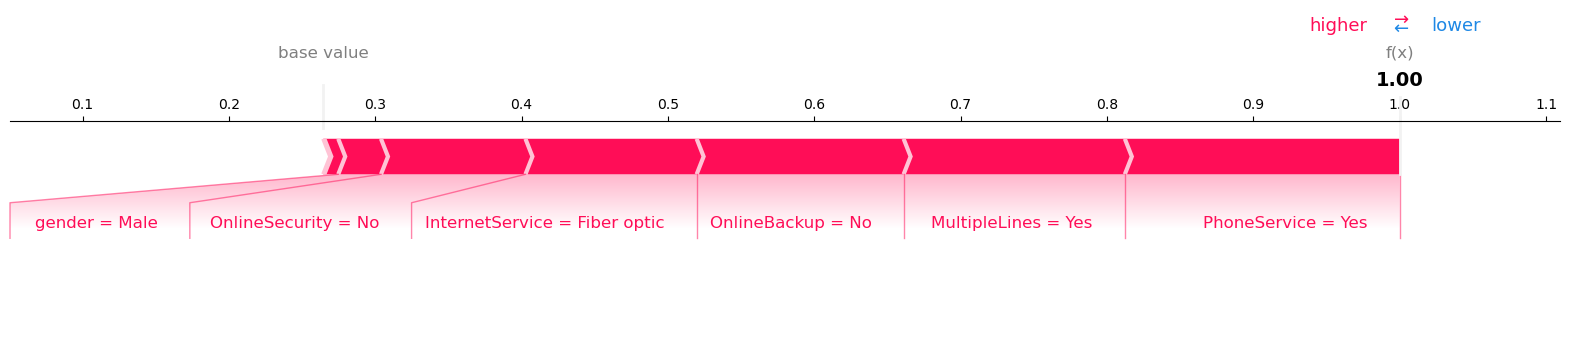

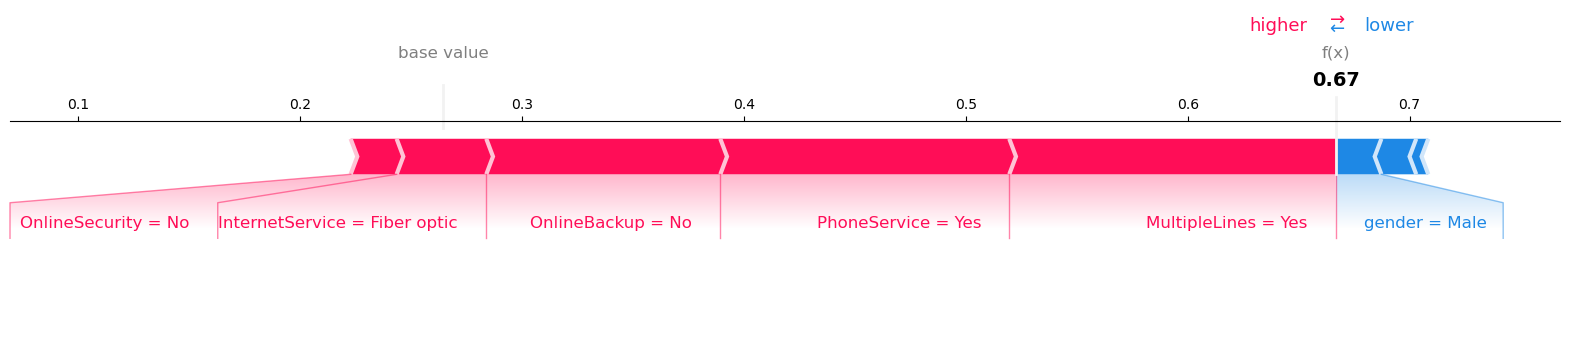

In [ ]:
idx_ejemplos_positivos = [2, 3]

kernel_explainer = shap.KernelExplainer(clf.predict_proba, X_combined_trans)

for idx in idx_ejemplos_positivos:
    
    # Obtener el ejemplo original y asegurarse de que las columnas coincidan
    ejemplo_original = X_test.iloc[idx, :][X_test_trans.columns]

    ejemplo = X_test_trans.loc[idx, :]
    kernel_shap_values = kernel_explainer.shap_values(ejemplo)

    # Mostrar el gráfico de SHAP
    shap.force_plot(
        kernel_explainer.expected_value[1], 
        kernel_shap_values[:, 1],  # Ojo aquí: kernel_shap_values es una lista
        ejemplo_original, 
        matplotlib=True
    )



### 8.2. Interpretabilidad Global:

  0%|          | 0/100 [00:00<?, ?it/s]

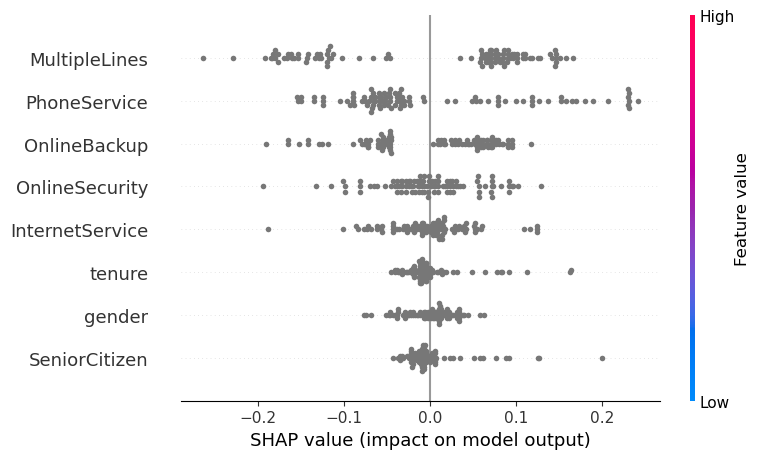

In [ ]:
# Si X_combined_trans era un DataFrame originalmente:
X_background = shap.sample(X_combined_trans, 100)

# Asegurarte de que es un DataFrame con columnas
if isinstance(X_background, np.ndarray):
    X_background = pd.DataFrame(X_background, columns=X_combined_trans.columns)

explainer = shap.KernelExplainer(clf.predict_proba, X_background)

shap_values = explainer.shap_values(X_background)

shap.summary_plot(shap_values[:, :, 1], X_background)

In [ ]:
X_background

,gender,SeniorCitizen,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup
4085,2842,0,5087,1233,1191,3332,1237,True
2689,2842,1,5087,2473,3088,3332,1222,False
2655,2842,0,5087,1233,3088,2302,1291,False
3888,2842,1,547,1928,3088,2302,1222,False
1507,2842,0,5087,1928,3088,3332,1884,False
...,...,...,...,...,...,...,...,...
1670,2842,0,5087,2473,3088,3332,1884,False
5339,2792,0,5087,2473,1355,3332,1884,True
3914,2842,0,5087,1928,3088,3332,1884,False
3523,2842,0,5087,2473,3088,3332,1884,False


In [ ]:
# Paso 1: Define una función que reciba una matriz X y devuelva predicciones del modelo
f = lambda x: RF.predict_proba(x)

# Paso 2: Toma un subset representativo del conjunto de entrenamiento como background
X_background = shap.sample(X_train, 100)  # o usar shap.kmeans(X_train, 10) para datos grandes

# Paso 3: Crear el KernelExplainer
explainer = shap.KernelExplainer(f, X_background)

# Paso 4: Elegir una muestra de datos para explicar (usar todo X_train es lento)
X_to_explain = shap.sample(X_train, 100)

# Paso 5: Calcular los valores SHAP
shap_values = explainer.shap_values(X_to_explain)

# Paso 6: Mostrar el resumen gráfico (para clasificación binaria: clase 1)
shap.summary_plot(shap_values[1], X_to_explain)
